# Loading Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import wfdb
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA

In [6]:
# Choosing the device you want : cpu , gpu or tpu

device_type = input("Please choose the type of device you want to use : ")
if device_type=="cpu":
    device = torch.device("cpu")
elif device_type=="gpu":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
elif device_type=="tpu":
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()

print("\nYou are using ", device)

Please choose the type of device you want to use : gpu

You are using  cuda:0


# Data Loading

In [8]:
signals,fields = wfdb.rdsamp("mit-bih-arrhythmia-database-1.0.0/100")
print(fields)

{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


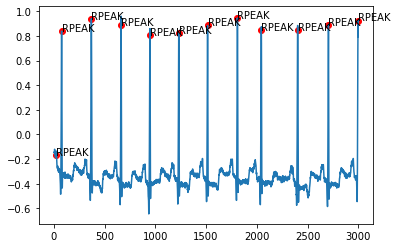

In [6]:
signal_v5 = signals[:,0].reshape(-1)

attr_check = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100',extension='atr')

plt.plot(signal_v5[:3000])
for i in attr_check.sample[attr_check.sample<3000]:
    plt.scatter(i,signal_v5[i],marker='o',c='r')
    plt.annotate("RPEAK",(i,signal_v5[i]))
plt.show()

# Data Preprocessing

In [9]:
records = np.loadtxt('mit-bih-arrhythmia-database-1.0.0/RECORDS',delimiter='\n').astype(int)
print(records)

[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


In [10]:
beat_classes = ['A','L','N','/','R','V','f','F','!','j']
beat_transform = {'A':0,'L':1,'N':2,'/':3,'R':4,'V':5,'f':6,'F':7,'!':8,'j':9}
beat_inv_transform = {v:k for k,v in beat_transform.items()}

In [11]:
ecg_signals = {}
ecg_labels = {}

for record in records :
    
    temp_signals,temp_fields = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/'+str(record))
    test_attr = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/'+str(record),extension='atr')
    ecg_labels[record] = {}
    ecg_labels[record]['sample'] = test_attr.sample
    ecg_labels[record]['symbol'] = test_attr.symbol
    ecg_labels[record]['full'] = [ (symbol,sample) for symbol,sample in zip(test_attr.symbol,test_attr.sample) ] 
    ecg_signals[record] = {}
    ecg_signals[record]['leads'] = temp_fields['sig_name']

    for n,i in enumerate(ecg_signals[record]['leads']):

        ecg_signals[record][i] = temp_signals[:,n].reshape(-1)

# Denoised Data Preprocessing

In [10]:
denoised_ecg_signals = {}

In [11]:
denoised_ecg_signals[0] = pd.read_parquet('mit_denoised_ecg_lead0.parquet')

In [12]:
denoised_ecg_signals[1] = pd.read_parquet('mit_denoised_ecg_lead1.parquet')

In [13]:
denoised_ecg_signals[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 48 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   100     650000 non-null  float32
 1   101     650000 non-null  float32
 2   102     650000 non-null  float32
 3   103     650000 non-null  float32
 4   104     650000 non-null  float32
 5   105     650000 non-null  float32
 6   106     650000 non-null  float32
 7   107     650000 non-null  float32
 8   108     650000 non-null  float32
 9   109     650000 non-null  float32
 10  111     650000 non-null  float32
 11  112     650000 non-null  float32
 12  113     650000 non-null  float32
 13  114     650000 non-null  float32
 14  115     650000 non-null  float32
 15  116     650000 non-null  float32
 16  117     650000 non-null  float32
 17  118     650000 non-null  float32
 18  119     650000 non-null  float32
 19  121     650000 non-null  float32
 20  122     650000 non-null  float32
 21  123     65

In [14]:
denoisedECGSignals = {}

In [15]:
for record in records:
    for lead in [0,1]:
        denoisedECGSignals[record] = {}
        denoisedECGSignals[record][lead] = denoised_ecg_signals[lead][str(record)]

# ECG Beat Segmentation

# Raw Data

In [12]:
fs = 360 # Sampling Rate
bp = 0.35
ap = 0.45

In [13]:
beat_matrix = []

In [14]:
for record in records:

    for lead in ecg_signals[record]['leads']:

        length = ecg_signals[record][lead].shape[0]

        for sym,samp in ecg_labels[record]['full']:

            if (((samp-bp*fs)>0) and ((samp+ap*fs)<length) and (sym in beat_classes)):

                beat_matrix.append([ecg_signals[record][lead][int(samp-bp*fs):int(samp+ap*fs)],beat_transform[sym]])

In [15]:
print(len(beat_matrix))


219054


# Plots for Paper

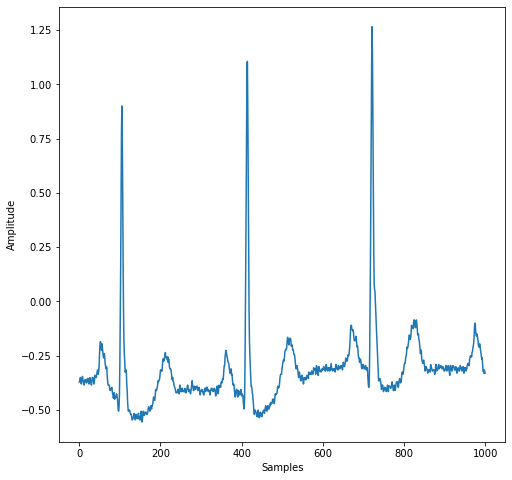

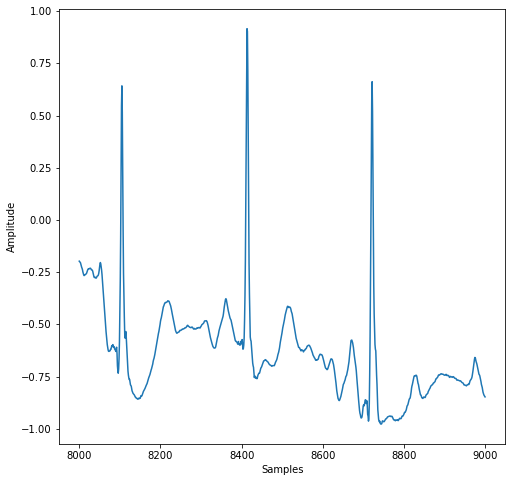

In [21]:
plt.figure(figsize=(8,8))

plt.plot(ecg_signals[101]['MLII'][8000:9000])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(8,8))

plt.plot(denoised_ecg_signals[0]['101'][8000:9000])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()



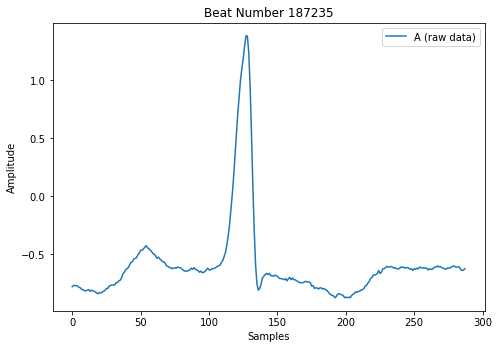

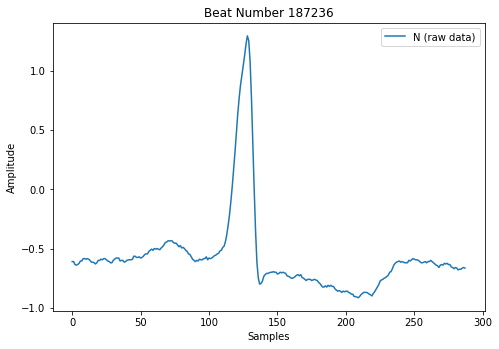

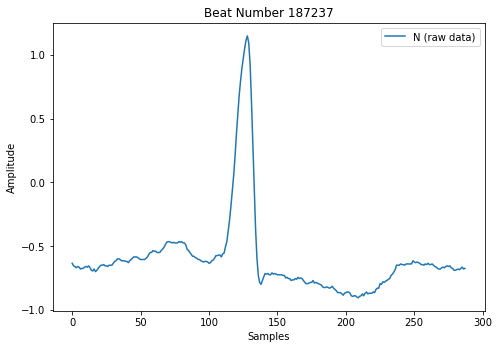

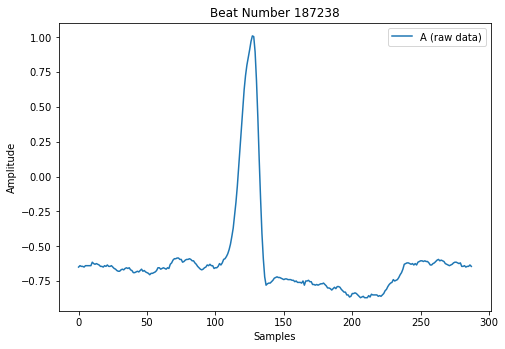

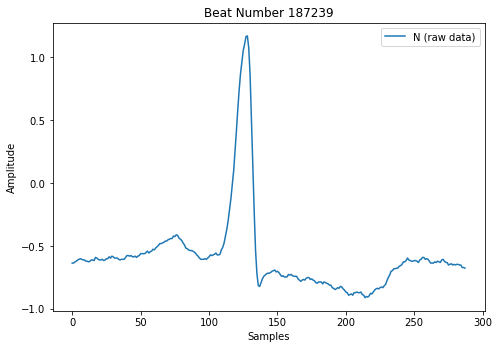

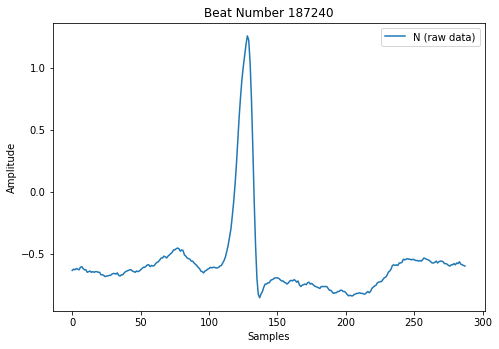

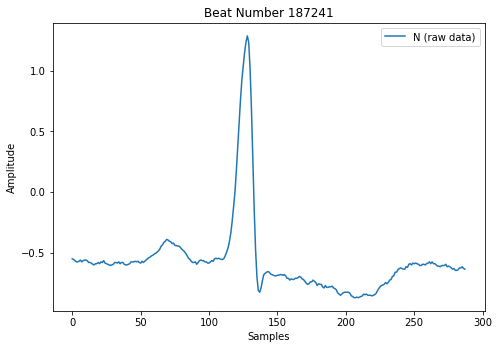

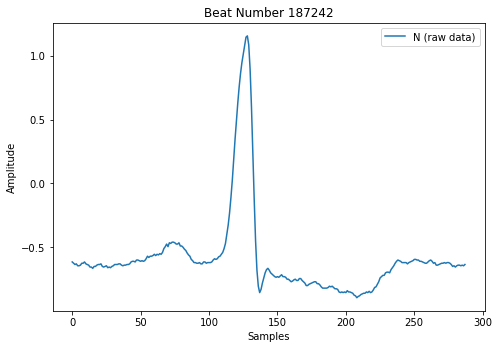

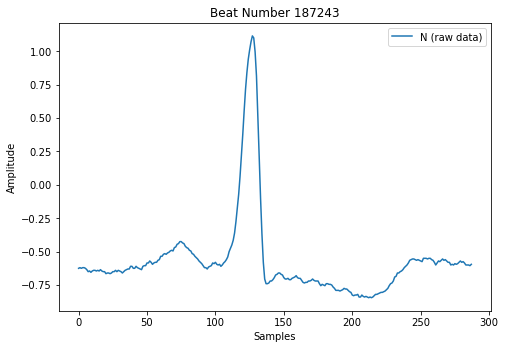

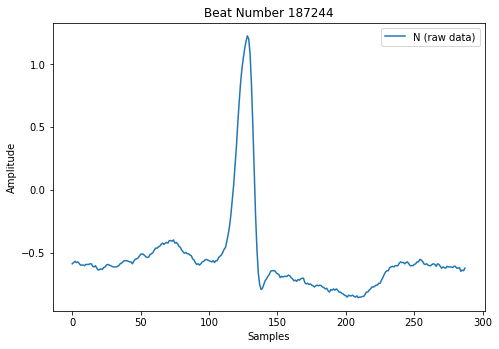

In [16]:
for i in range(187235,187245):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot([p for p in range(288)],beat_matrix[i][0],label
            =beat_inv_transform[beat_matrix[i][1]]+" (raw data)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.title("Beat Number "+str(i))
    plt.legend()
    plt.show()

Text(0, 0.5, 'Amplitude')

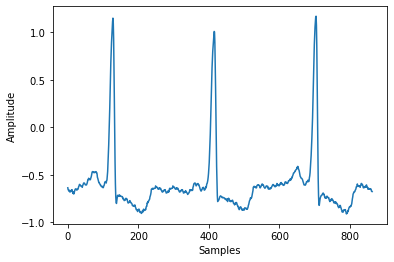

In [28]:
p = np.append(beat_matrix[187237][0],beat_matrix[187238][0])
p = np.append(p,beat_matrix[187239][0])
plt.plot([p for p in range(864)],p)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
#print(beat_matrix[187237][0].shape)

In [23]:
beat_matrix = np.array(beat_matrix)

## Denoised

In [24]:
denoised_beat_matrix = []

In [25]:
for record in records:

    for lead in [0,1]:

        length = denoised_ecg_signals[lead][str(record)].shape[0]

        for sym,samp in ecg_labels[record]['full']:

            if (((samp-bp*fs)>0) and ((samp+ap*fs)<length) and (sym in beat_classes)):

                denoised_beat_matrix.append([denoised_ecg_signals[lead][str(record)][int(samp-bp*fs):int(samp+ap*fs)],beat_transform[sym]])

In [26]:
print(len(denoised_beat_matrix))
denoised_beat_matrix = np.array(denoised_beat_matrix)

219054


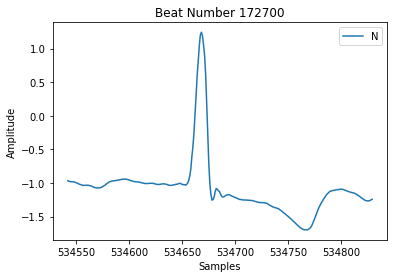

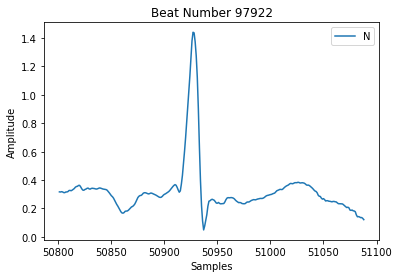

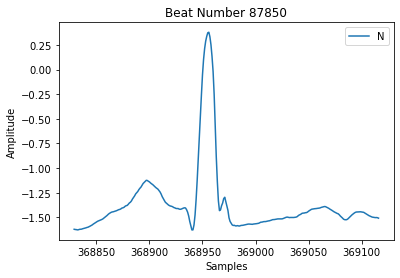

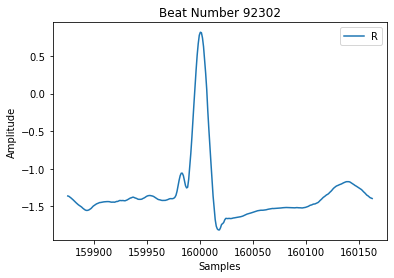

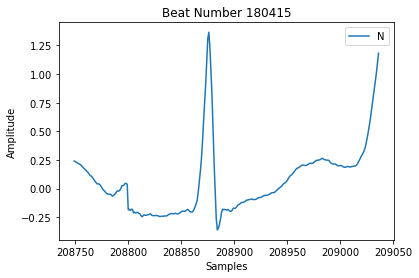

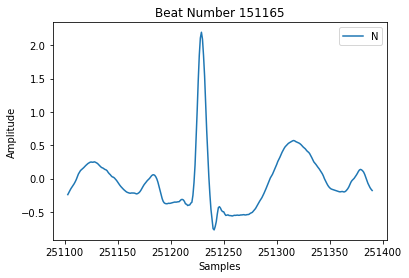

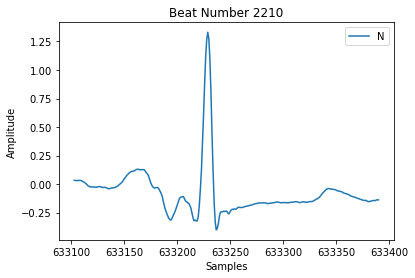

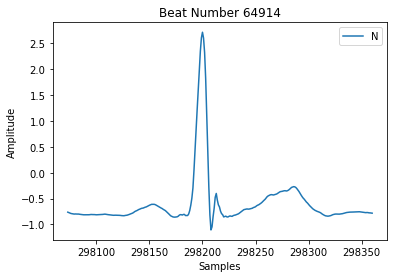

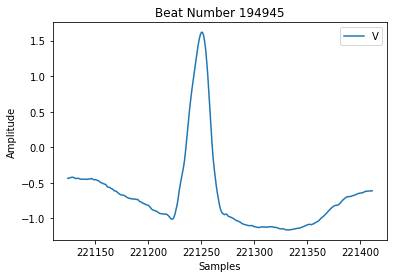

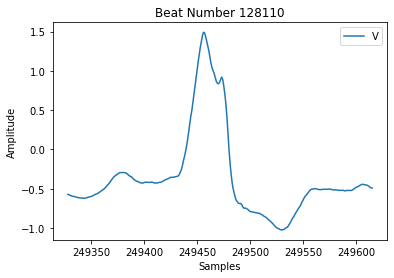

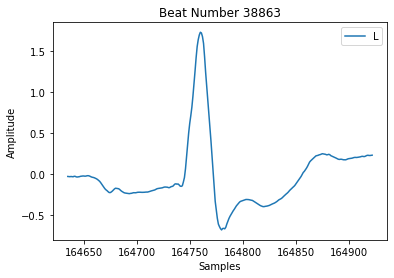

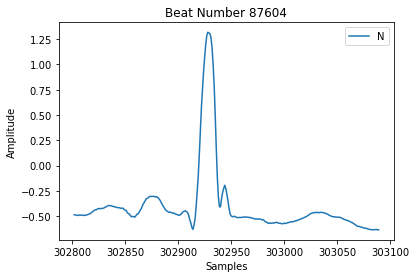

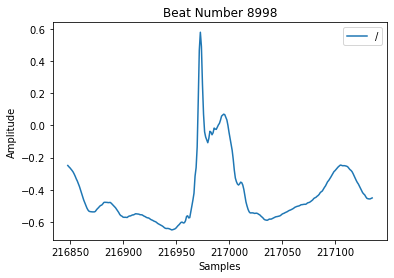

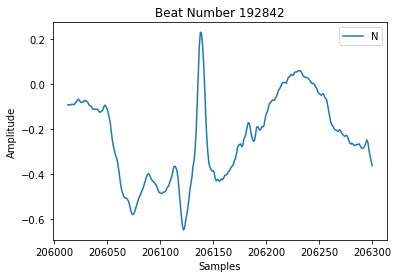

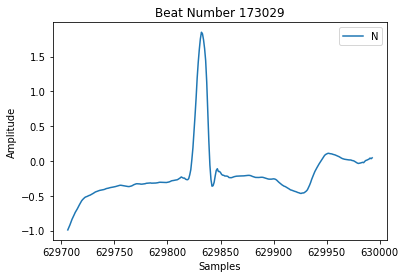

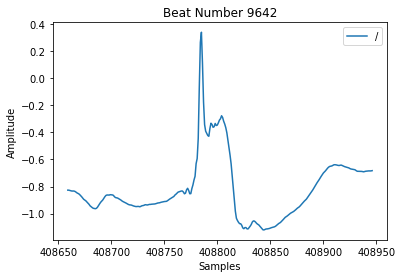

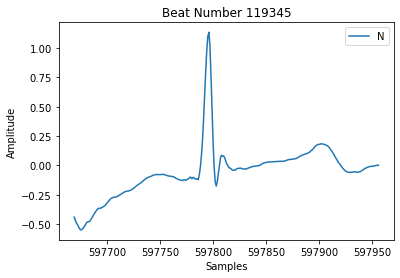

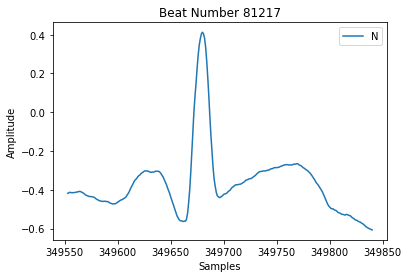

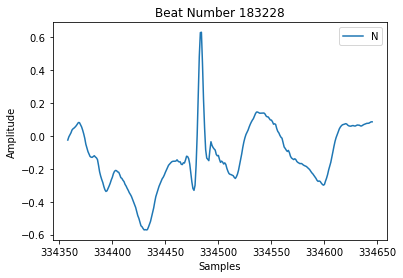

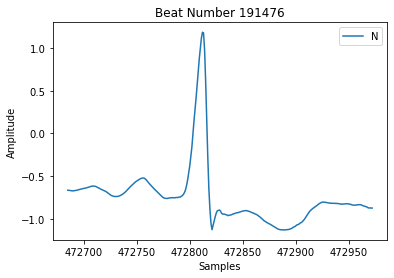

In [27]:
for i in np.random.randint(0,len(denoised_beat_matrix),20):
    plt.plot(denoised_beat_matrix[i][0],label=beat_inv_transform[denoised_beat_matrix[i][1]])
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.title("Beat Number "+str(i))
    plt.legend()
    plt.show()

## Denoised (EMD+DWT)

In [28]:
emd_denoised_beat_matrix = []
for record in records:

    for lead in [0,1]:

        length = emd_denoised_ecg_signals[lead][str(record)].shape[0]

        for sym,samp in ecg_labels[record]['full']:

            if (((samp-bp*fs)>0) and ((samp+ap*fs)<length) and (sym in beat_classes)):

                emd_denoised_beat_matrix.append([emd_denoised_ecg_signals[lead][str(record)][int(samp-bp*fs):int(samp+ap*fs)],beat_transform[sym]])
                
emd_denoised_beat_matrix = np.array(emd_denoised_beat_matrix)

# Data Preparation

In [29]:
X_train, X_test_, y_train, y_test_ = train_test_split(beat_matrix[:,0],beat_matrix[:,1],test_size=0.2,shuffle=True,stratify=beat_matrix[:,1],random_state=1)
X_test,X_val,y_test,y_val = train_test_split(X_test_,y_test_,test_size=0.5,shuffle=True,stratify=y_test_,random_state=1)

X_train = np.array(list(X_train))
y_train = np.array(list(y_train))
X_val = np.array(list(X_val))
y_val = np.array(list(y_val))
X_test = np.array(list(X_test))
y_test = np.array(list(y_test))

print(" The shape of X_train is ",X_train.shape)
print(" The shape of y_train is ",y_train.shape)
print(" The shape of X_val is ",X_val.shape)
print(" The shape of y_val is ",y_val.shape)
print(" The shape of X_test is ",X_test.shape)
print(" The shape of y_test is ",y_test.shape)

 The shape of X_train is  (175243, 288)
 The shape of y_train is  (175243,)
 The shape of X_val is  (21906, 288)
 The shape of y_val is  (21906,)
 The shape of X_test is  (21905, 288)
 The shape of y_test is  (21905,)


## Batching

### Training

In [30]:
batch_size = 31
n_batches = X_train.shape[0]/batch_size

train_dict = {}
train_dict['batches'] = {}
val_dict = {}
test_dict = {}

train_dict['X_train'] = X_train
train_dict['y_train'] = y_train
val_dict['X_val'] = X_val
val_dict['y_val'] = y_val
test_dict['X_test'] = X_test
test_dict['y_test'] = y_test

train_dict['batches']['X'] = np.split(X_train,n_batches)
train_dict['batches']['y'] = np.split(y_train,n_batches)

train_dict['batches']['X'][0].shape

(31, 288)

In [31]:
train_dict['batches']['X'][0].shape

(31, 288)

### Validation

In [32]:
batch_size_val = 1217
n_batches_val = X_val.shape[0]/batch_size_val

val_dict['batches'] = {}

val_dict['batches']['X'] = np.split(X_val,n_batches_val)
val_dict['batches']['y'] = np.split(y_val,n_batches_val)

print(val_dict['batches']['X'][0].shape)

(1217, 288)


### Test

In [33]:
batch_size_test = 1685
n_batches_test = X_test.shape[0]/batch_size_test


test_dict['batches'] = {}

test_dict['batches']['X'] = np.split(X_test,n_batches_test)
test_dict['batches']['y'] = np.split(y_test,n_batches_test)

print(test_dict['batches']['X'][0].shape)

(1685, 288)


# Denoised Data Preparation

In [34]:
dX_train, dX_test_, dy_train, dy_test_ = train_test_split(denoised_beat_matrix[:,0],denoised_beat_matrix[:,1],test_size=0.2,shuffle=True,stratify=denoised_beat_matrix[:,1],random_state=1)
dX_test,dX_val,dy_test,dy_val = train_test_split(dX_test_,dy_test_,test_size=0.5,shuffle=True,stratify=dy_test_,random_state=1)

dX_train = np.array(list(dX_train))
dy_train = np.array(list(dy_train))
dX_val = np.array(list(dX_val))
dy_val = np.array(list(dy_val))
dX_test = np.array(list(dX_test))
dy_test = np.array(list(dy_test))

print(" The shape of X_train is ",dX_train.shape)
print(" The shape of y_train is ",dy_train.shape)
print(" The shape of X_val is ",dX_val.shape)
print(" The shape of y_val is ",dy_val.shape)
print(" The shape of X_test is ",dX_test.shape)
print(" The shape of y_test is ",dy_test.shape)

 The shape of X_train is  (175243, 288)
 The shape of y_train is  (175243,)
 The shape of X_val is  (21906, 288)
 The shape of y_val is  (21906,)
 The shape of X_test is  (21905, 288)
 The shape of y_test is  (21905,)


## Batching

### Training

In [35]:
batch_size = 31
n_batches = dX_train.shape[0]/batch_size

dtrain_dict = {}
dtrain_dict['batches'] = {}
dval_dict = {}
dtest_dict = {}

dtrain_dict['X_train'] = dX_train
dtrain_dict['y_train'] = dy_train
dval_dict['X_val'] = dX_val
dval_dict['y_val'] = dy_val
dtest_dict['X_test'] = dX_test
dtest_dict['y_test'] = dy_test

dtrain_dict['batches']['X'] = np.split(dX_train,n_batches)
dtrain_dict['batches']['y'] = np.split(dy_train,n_batches)

dtrain_dict['batches']['X'][0].shape

(31, 288)

In [36]:
dtrain_dict['batches']['X'][0].shape

(31, 288)

### Validation

In [37]:
batch_size_val = 1217
n_batches_val = dX_val.shape[0]/batch_size_val

dval_dict['batches'] = {}

dval_dict['batches']['X'] = np.split(dX_val,n_batches_val)
dval_dict['batches']['y'] = np.split(dy_val,n_batches_val)

print(dval_dict['batches']['X'][0].shape)

(1217, 288)


### Test

In [38]:
batch_size_test = 1685
n_batches_test = dX_test.shape[0]/batch_size_test


dtest_dict['batches'] = {}

dtest_dict['batches']['X'] = np.split(dX_test,n_batches_test)
dtest_dict['batches']['y'] = np.split(dy_test,n_batches_test)

print(dtest_dict['batches']['X'][0].shape)

(1685, 288)


# HeartNet Model for Beat Classification

In [44]:
class HeartNetEC(nn.Module):

    def __init__(self,length):


        super().__init__()
        self.length = length

        self.descend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=1,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,1,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (1,4,L) --> (1,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.descend_Stage1_i_Stage2 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,4,L) --> (N,4,L/2)

        self.descend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=4,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,4,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.descend_Stage2_i_Stage3 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,8,L/2) --> (N,8,L/4)

        self.descend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=8,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,8,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),#(N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.descend_Stage3_i_Stage4 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,16,L/4) --> (N,16,L/8)

        self.descend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=16,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,16,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.descend_Stage4_i_floor = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,32,L/8) --> (N,32,L/16)

        self.floor = nn.Sequential(

            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,32,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU(),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,64,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU()
        )

        self.ascend_floor_i_Stage4 = nn.ConvTranspose1d(in_channels=64,out_channels=64,kernel_size=8,stride=2,padding=3) # (N,64,L/16) --> (N,64,L/8)

        self.ascend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=96,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,96,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.ascend_Stage4_i_Stage3 = nn.ConvTranspose1d(in_channels=32,out_channels=32,kernel_size=8,stride=2,padding=3) # (N,32,L/8) --> (N,32,L/4)

        self.ascend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=48,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,48,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.ascend_Stage3_i_Stage2 = nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=8,stride=2,padding=3) # (N,16,L/4) --> (N,16,L/2)

        self.ascend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=24,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,24,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.ascend_Stage2_i_Stage1 = nn.ConvTranspose1d(in_channels=8,out_channels=8,kernel_size=8,stride=2,padding=3) # (N,8,L/2) --> (N,8,L)

        self.ascend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=12,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,12,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,4,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.fe_output = nn.Conv1d(in_channels=4,out_channels=1,kernel_size=1)          # (N,4,L) --> (N,1,L)

        self.cl_stage_1 = nn.Sequential(
            
            nn.Linear(in_features=self.length,out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final_stage = nn.Linear(in_features=64,out_features=10)


    def forward(self,x):

  

        # Pass through Descend Stage-1

        d_1 = self.descend_Stage1(x)



        # Move to Descend Stage-2

        d_1_i_2 = self.descend_Stage1_i_Stage2(d_1)

 

        # Pass through Descend Stage-2

        d_2 = self.descend_Stage2(d_1_i_2)

  

        # Move to Descend Stage-3

        d_2_i_3 = self.descend_Stage2_i_Stage3(d_2)



        # Pass through Descend Stage-3

        d_3 = self.descend_Stage3(d_2_i_3)



        # Move to Descend Stage-4


        d_3_i_4 = self.descend_Stage3_i_Stage4(d_3)



        # Pass through Descend Stage-4

        d_4 = self.descend_Stage4(d_3_i_4)



        # Move to Floor

        d_4_i_f = self.descend_Stage4_i_floor(d_4)



        # Pass through Floor

        d_f = self.floor(d_4_i_f)



        # Move to Ascend Stage-4

        a_f_i_4 = self.ascend_floor_i_Stage4(d_f)


        # Prepare for Ascend Stage-4



        a_p_4 = torch.cat((d_4,a_f_i_4),dim=1)


        # Pass through Ascend Stage-4


        a_4 = self.ascend_Stage4(a_p_4)


        # Move to Ascend Stage-3


        a_4_i_3 = self.ascend_Stage4_i_Stage3(a_4)


        # Prepare for Ascend Stage-3


        a_p_3 = torch.cat((d_3,a_4_i_3),dim=1)


        # Pass through Ascend Stage-3


        a_3 = self.ascend_Stage3(a_p_3)


        # Move to Ascend Stage-2

        a_3_i_2 = self.ascend_Stage3_i_Stage2(a_3)


        # Prepare for Ascend Stage-2

        a_p_2 = torch.cat((d_2,a_3_i_2),dim=1)


        # Pass through Stage-2

        a_2 = self.ascend_Stage2(a_p_2)


        # Move to Ascend Stage-1

        a_2_i_1 = self.ascend_Stage2_i_Stage1(a_2)



        # Prepare for Ascend Stage-1

        a_p_1 = torch.cat((d_1,a_2_i_1),dim=1)


        # Pass through Ascend Stage-1


        a_1 = self.ascend_Stage1(a_p_1)


        # Pass through Final Stage of Feature Extractor


        fe_output = self.fe_output(a_1)

        # Pass through FF Stage - 1

        cl_out_1 = self.cl_stage_1(fe_output.squeeze())

        # Pass through the Final Classifier Stage

        final_output = self.final_stage(cl_out_1)


        return final_output

In [45]:
tst = HeartNetEC(288)
print(tst)

HeartNetEC(
  (descend_Stage1): Sequential(
    (0): Conv1d(1, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(4, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage1_i_Stage2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage2): Sequential(
    (0): Conv1d(4, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage2_i_Stage3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage3): Sequ

# Evaluator

## Helper Functions

In [46]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories,
                annot_kws={"size":17,"weight": "bold"})

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    plt.show()

In [47]:
def evaluation(model,config,data,trueLabels,mode,name):

    """ Main Evaluator Function """

    predictedLabels = []

    for data_batch in data:

        data_batch = torch.FloatTensor(data_batch.reshape(config[name],1,-1)).to(device)

        with torch.no_grad():
            temp_predictions = model(data_batch)

    
        del data_batch
        torch.cuda.empty_cache()
        
        predictedLabels = np.append(predictedLabels,list(np.argmax(np.array(temp_predictions.cpu()),axis=1)))




    conf_mat = confusion_matrix(trueLabels,predictedLabels)

    num_TP = {}
    num_FP = {}
    num_FN = {}
    num_TN = {}

    num_TP['all'] = 0
    num_FP['all'] = 0
    num_FN['all'] = 0


    for beat_type in config['beat_classes']:

        num_TP[beat_type] = float(conf_mat[config['beat_transform'][beat_type],config['beat_transform'][beat_type]])
        num_FP[beat_type] = np.sum(conf_mat[:,config['beat_transform'][beat_type]]) - num_TP[beat_type]
        num_FN[beat_type] = np.sum(conf_mat[config['beat_transform'][beat_type],:]) - num_TP[beat_type]
        num_TN[beat_type] = np.sum(conf_mat) - num_TP[beat_type] - num_FP[beat_type] - num_FN[beat_type]

        num_TP['all'] += num_TP[beat_type]
        num_FP['all'] += num_FP[beat_type]
        num_FN['all'] += num_FN[beat_type]

    precision_full = (num_TP['all']/(num_TP['all']+num_FP['all']))
    sensitivity_full = (num_TP['all']/(num_TP['all']+num_FN['all']))
    f1_full = (2*precision_full*sensitivity_full)/(precision_full+sensitivity_full)
    accuracy_full = (num_TP['all'])/np.sum(conf_mat)

    if mode == "Validation":

        return {"accuracy":accuracy_full,
                "precision":precision_full,
                "sensitivity":sensitivity_full,
                "F1":f1_full
               }

    if mode == "Evaluation":

        metrics = classification_report(trueLabels,predictedLabels,target_names=config['beat_classes'],output_dict=True)

        for beat_type in config['beat_classes']:

            metrics[beat_type]["Accuracy"] = (num_TP[beat_type]+num_TN[beat_type])/np.sum(conf_mat)

        metrics['all'] = {}

        metrics['all']['precision'] = precision_full 
        metrics['all']['recall'] = sensitivity_full
        metrics['all']['f1-score'] = f1_full
        metrics['all']['Accuracy'] = accuracy_full

        return metrics,conf_mat

# Core Training Setup

In [49]:
config = {}

config['batch_size'] = batch_size
config['n_batches'] = n_batches
config['batch_size_val'] = batch_size_val
config['n_batches_val'] = n_batches_val
config['batch_size_test'] = batch_size_test
config['n_batches_test'] = n_batches_test
config['feature_length'] = 288
config['lr'] = 0.001
config['device'] = device
config['device_type'] = device_type
config['beat_classes'] = beat_classes
config['beat_transform'] = beat_transform
config['beat_inv_transform'] = beat_inv_transform

## Core Training Function

In [50]:
def ultimate_trainer(trainData,valData,testData,epochs,config,verbose=False,visualize=True,download_model=False):

    """ Trains HeartNet Models for Beat Classification """

    print("------------------------------------------------------------------------------------------")
    print("\t\t\t TRAINING EXPERIMENT")
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING CONFIGURATION")
    print("------------------------------------------------------------------------------------------")

    print("--> The HeartNet Model is being trained for Beat Classification")
    print("--> You are using a  " + config['device_type'])
    print("--> The epochs specified for training : ",epochs)
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING")
    print("------------------------------------------------------------------------------------------")


    # Model Instantiation and Model Parameters

    model = HeartNetEC(config['feature_length'])

    model = model.to(config['device'])

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr=config['lr'])

    # Some variables for Training and Validation Visualization
    sensitivity_plot_val = []
    precision_plot_val = []
    F1_plot_val = []
    accuracy_plot_val = []

    loss_train_plot = []
    sensitivity_plot_train = []
    precision_plot_train = []
    F1_plot_train = []
    accuracy_plot_train = []

    # Some variables for Checkpointing

    min_train_loss = 1000
    max_val_F1 = 0
    max_train_F1 = 0

    # Training

    for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):

        # Now go through each batch

        for train_batch,label_batch in zip(trainData['batches']['X'],trainData['batches']['y']):

            # Convert to Tensors

            train_batch = torch.FloatTensor(train_batch.reshape(batch_size,1,-1))

            label_batch = torch.LongTensor(label_batch)

            # Move to Specified Device

            train_batch,label_batch = train_batch.to(device),label_batch.to(device)

            # Initialize gradients to zero
            
            optimizer.zero_grad()

            # Forward Pass

            prediction = model(train_batch)

            # Compute the Loss
            

            loss = loss_fn(prediction,label_batch)

            # Backpropagation

            loss.backward()

            # Take a Step and update the parameters

            optimizer.step()

            # Now Checkpointing the model loss

            if min_train_loss > loss.item() :

                min_train_loss = loss.item()
                #best_train_model = copy.deepcopy(model.state_dict())
                print("+-> Min Training Loss : "+str(min_train_loss))

            # Freeing the GPU

            del train_batch,label_batch,prediction
            torch.cuda.empty_cache()

        # Some Bookkeeping for Training

        loss_train_plot.append(loss.item())

        # Put the Model in Evaluation Mode

        model.eval()

        # Evaluating Train Data

        train_metrics,val_metrics = evaluation(model=model,config=config,data=trainData['batches']['X'],trueLabels=trainData['y_train'],mode='Validation',name='batch_size'),evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Validation',name='batch_size_val')


        # Bookkeeping

        sensitivity_plot_train.append(train_metrics['sensitivity'])
        precision_plot_train.append(train_metrics['precision'])
        F1_plot_train.append(train_metrics['F1'])
        accuracy_plot_train.append(train_metrics['accuracy'])

        sensitivity_plot_val.append(val_metrics['sensitivity'])
        precision_plot_val.append(val_metrics['precision'])
        F1_plot_val.append(val_metrics['F1'])
        accuracy_plot_val.append(val_metrics['accuracy'])

        # Checkpointing the Best Validation Model

        if max_val_F1 < val_metrics['F1']:

            max_val_F1 = val_metrics['F1']

            best_val_model = copy.deepcopy(model.state_dict())

            print("+-> Maximum Validation F1 (in %) obtained is ",max_val_F1)

        # Put the Model back in Training Mode

        model.train()

    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING COMPLETE")
    print("------------------------------------------------------------------------------------------")
    plt.plot(loss_train_plot,'r-')
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss : Cross Entropy Loss")
    plt.title("LOSS PLOT")
    plt.show()

    if visualize :
        print("------------------------------------------------------------------------------------------")
        print("\t VISUALIZATION ")
        print("------------------------------------------------------------------------------------------")
        # Visualization

        plt.plot(accuracy_plot_train,'r-',label='Train Data')
        plt.plot(accuracy_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()


        plt.plot(sensitivity_plot_train,'r-',label='Train Data')
        plt.plot(sensitivity_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Sensitivity")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(precision_plot_train,'r-',label='Train Data')
        plt.plot(precision_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(F1_plot_train,'r-',label='Train Data')
        plt.plot(F1_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("F1 Score")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        print("------------------------------------------------------------------------------------------")
        print("\t METRICS FOR BEST VALIDATION MODEL")
        print("------------------------------------------------------------------------------------------")
        print("VALIDATION SET")
        print("------------------------------------------------------------------------------------------")

        model.load_state_dict(best_val_model)

        model.eval()

        best_metrics_val,conf_matrix_val = evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Evaluation',name='batch_size_val')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_val,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_val = pd.DataFrame.from_dict(best_metrics_val)
        df_val = df_val.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_val = df_val.drop(['support'],axis=0)
        display(df_val.T)

        print("------------------------------------------------------------------------------------------")
        print("TEST SET")
        print("------------------------------------------------------------------------------------------")

        best_metrics_test,conf_matrix_test = evaluation(model=model,config=config,data=testData['batches']['X'],trueLabels=testData['y_test'],mode='Evaluation',name='batch_size_test')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_test,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_test = pd.DataFrame.from_dict(best_metrics_test)
        df_test = df_test.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_test = df_test.drop(['support'],axis=0)
        display(df_test.T)

        print("------------------------------------------------------------------------------------------")
        print("\t EVALUATION COMPLETE")
        print("------------------------------------------------------------------------------------------")

    # Now download the model for future use

    if download_model :

        print("DOWNLOADING MODEL ...")

        torch.save(best_val_model,"HRT_NET_MODEL_MIT_50")


        print("DOWNLOADING COMPLETE !!!")


    return best_val_model

# Saved Model Evaluator

In [51]:
def savedModelEvaluator(filename,trainData,valData,testData,config):
    
    print("------------------------------------------------------------------------------------------")
    print("\t METRICS FOR BEST VALIDATION MODEL")
    print("------------------------------------------------------------------------------------------")
    print("VALIDATION SET")
    print("------------------------------------------------------------------------------------------")

    model = HeartNetEC(config['feature_length'])

    model = model.to(config['device'])

    model.load_state_dict(torch.load(filename,map_location=config['device']))

    model.eval()

    best_metrics_val,conf_matrix_val = evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Evaluation',name='batch_size_val')

    print("Confusion Matrix\n\n")

    make_confusion_matrix(conf_matrix_val,
                      categories=config['beat_classes'],
                      count=True,
                      percent=False,
                      cbar=True,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=False,
                      figsize=(15,15),
                      cmap='Blues',
                      title=None)

    print("\n\nMetrics\n\n")

    df_val = pd.DataFrame.from_dict(best_metrics_val)
    df_val = df_val.drop(['accuracy','macro avg','weighted avg'],axis=1)
    df_val = df_val.drop(['support'],axis=0)
    display(df_val.T)

    print("------------------------------------------------------------------------------------------")
    print("TEST SET")
    print("------------------------------------------------------------------------------------------")

    best_metrics_test,conf_matrix_test = evaluation(model=model,config=config,data=testData['batches']['X'],trueLabels=testData['y_test'],mode='Evaluation',name='batch_size_test')

    print("Confusion Matrix\n\n")

    make_confusion_matrix(conf_matrix_test,
                      categories=config['beat_classes'],
                      count=True,
                      percent=False,
                      cbar=True,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=False,
                      figsize=(15,15),
                      cmap='Blues',
                      title=None)

    print("\n\nMetrics\n\n")

    df_test = pd.DataFrame.from_dict(best_metrics_test)
    df_test = df_test.drop(['accuracy','macro avg','weighted avg'],axis=1)
    df_test = df_test.drop(['support'],axis=0)
    display(df_test.T)

    print("------------------------------------------------------------------------------------------")
    print("\t EVALUATION COMPLETE")
    print("------------------------------------------------------------------------------------------")


# Denoised Training

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  10
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-79-1a8aa4e3184e>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.3692731857299805
+-> Min Training Loss : 2.290849208831787
+-> Min Training Loss : 2.1985745429992676
+-> Min Training Loss : 2.1535208225250244
+-> Min Training Loss : 2.0628950595855713
+-> Min Training Loss : 1.8715713024139404
+-> Min Training Loss : 1.8618041276931763
+-> Min Training Loss : 1.784211277961731
+-> Min Training Loss : 1.6274945735931396
+-> Min Training Loss : 1.5374854803085327
+-> Min Training Loss : 1.4194830656051636
+-> Min Training Loss : 1.4141230583190918
+-> Min Training Loss : 1.3955127000808716
+-> Min Training Loss : 1.354032278060913
+-> Min Training Loss : 1.3176014423370361
+-> Min Training Loss : 1.1469573974609375
+-> Min Training Loss : 1.094791054725647
+-> Min Training Loss : 0.9610127210617065
+-> Min Training Loss : 0.7711389064788818
+-> Min Training Loss : 0.756195068359375
+-> Min Training Loss : 0.7521746158599854
+-> Min Training Loss : 0.6096413135528564
+-> Min Training Loss : 0.6085106134414673
+-> Min Training

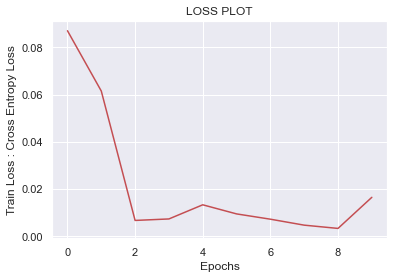

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


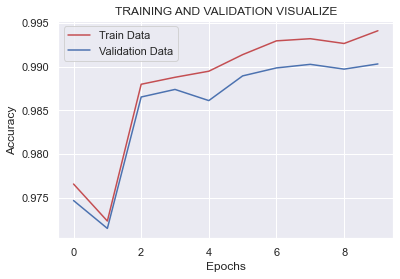

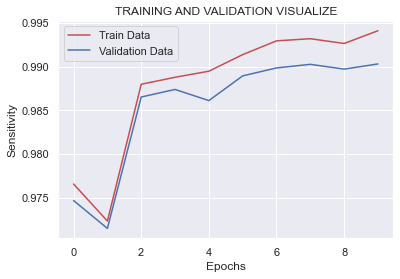

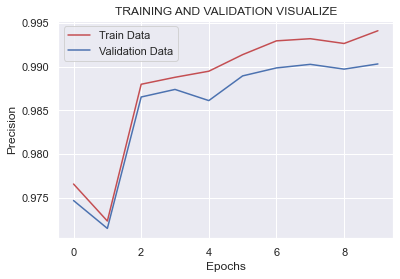

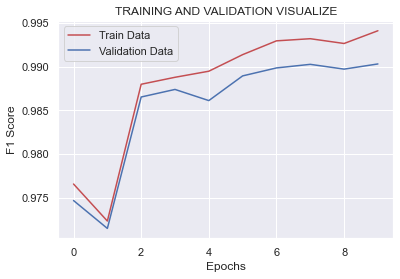

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




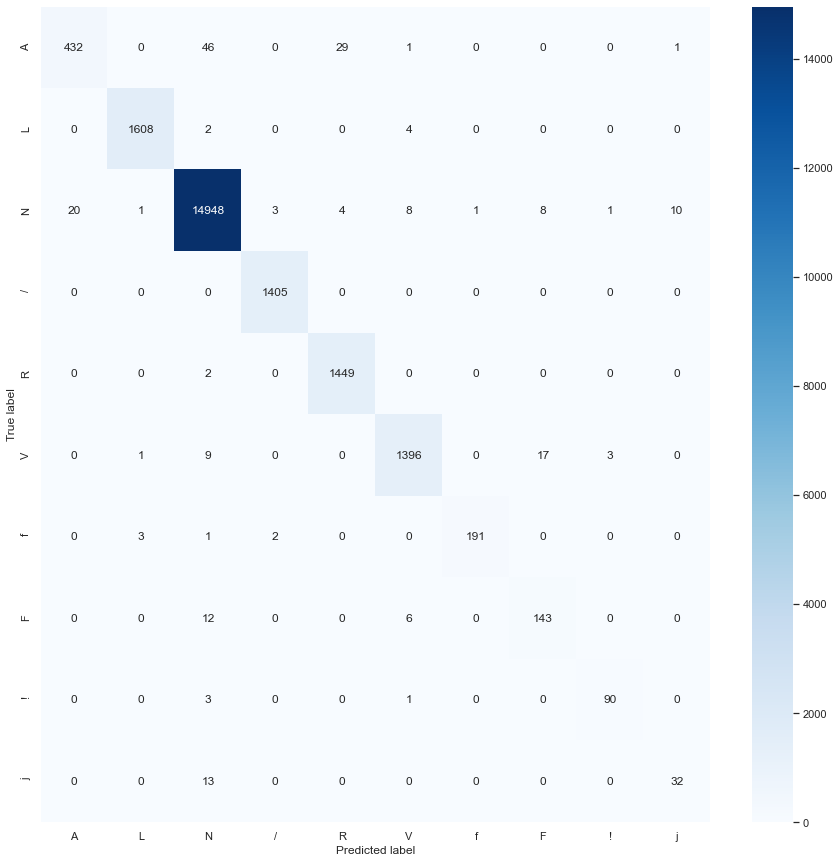



Metrics




,precision,recall,f1-score,Accuracy
A,0.955752,0.848723,0.899063,0.995572
L,0.996900,0.996283,0.996591,0.999498
N,0.994147,0.996268,0.995206,0.993426
/,0.996454,1.000000,0.998224,0.999772
R,0.977733,0.998622,0.988067,0.998402
V,0.985876,0.978962,0.982407,0.997718
f,0.994792,0.969543,0.982005,0.999680
F,0.851190,0.888199,0.869301,0.998037
!,0.957447,0.957447,0.957447,0.999635
j,0.744186,0.711111,0.727273,0.998904


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




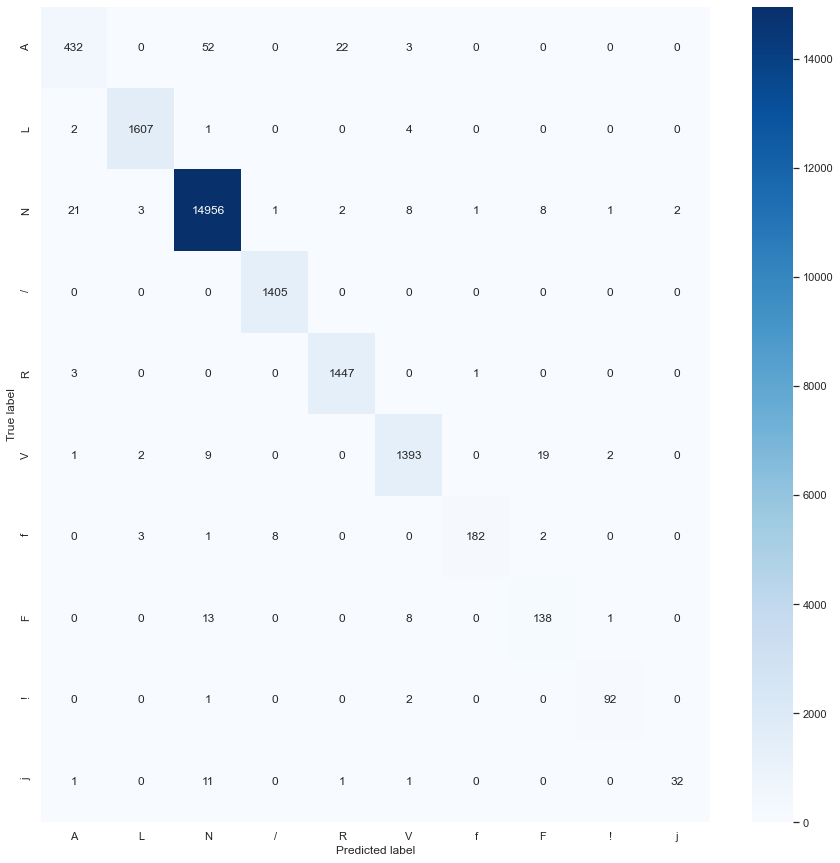



Metrics




,precision,recall,f1-score,Accuracy
A,0.939130,0.848723,0.891641,0.995207
L,0.995046,0.995663,0.995355,0.999315
N,0.994150,0.996867,0.995507,0.993837
/,0.993635,1.000000,0.996807,0.999589
R,0.983016,0.997243,0.990079,0.998676
V,0.981677,0.976858,0.979262,0.997307
f,0.989130,0.928571,0.957895,0.999270
F,0.826347,0.862500,0.844037,0.997672
!,0.958333,0.968421,0.963351,0.999680
j,0.941176,0.695652,0.800000,0.999270


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...


NameError: name 'files' is not defined

In [80]:
best_val_model = ultimate_trainer(trainData=dtrain_dict,valData=dval_dict,testData=dtest_dict,epochs=10,config=config,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-55-fc9ef249c7ef>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.2393510341644287
+-> Min Training Loss : 2.1712639331817627
+-> Min Training Loss : 1.9634028673171997
+-> Min Training Loss : 1.94952392578125
+-> Min Training Loss : 1.8878004550933838
+-> Min Training Loss : 1.7617684602737427
+-> Min Training Loss : 1.7014676332473755
+-> Min Training Loss : 1.635062336921692
+-> Min Training Loss : 1.549747347831726
+-> Min Training Loss : 1.4133683443069458
+-> Min Training Loss : 1.372014045715332
+-> Min Training Loss : 1.3375533819198608
+-> Min Training Loss : 1.285099983215332
+-> Min Training Loss : 1.153971552848816
+-> Min Training Loss : 1.047878623008728
+-> Min Training Loss : 1.0264359712600708
+-> Min Training Loss : 0.8294740319252014
+-> Min Training Loss : 0.7787970900535583
+-> Min Training Loss : 0.7413002252578735
+-> Min Training Loss : 0.686191737651825
+-> Min Training Loss : 0.6664779186248779
+-> Min Training Loss : 0.6150602102279663
+-> Min Training Loss : 0.6068516373634338
+-> Min Training Los

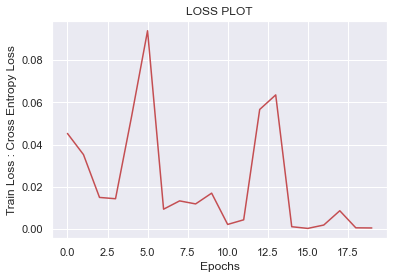

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


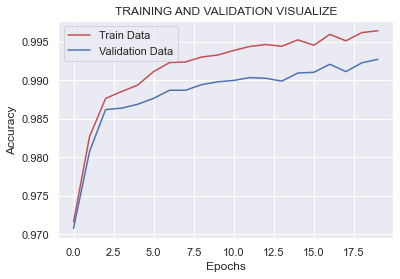

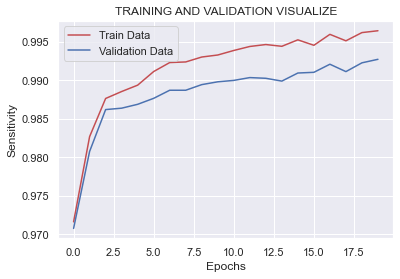

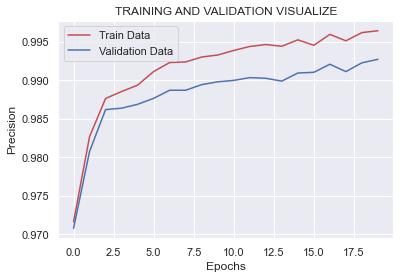

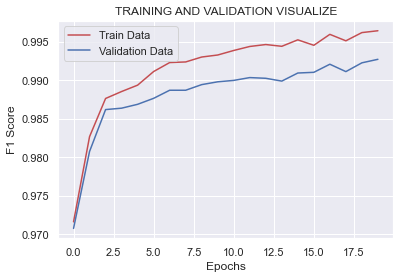

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




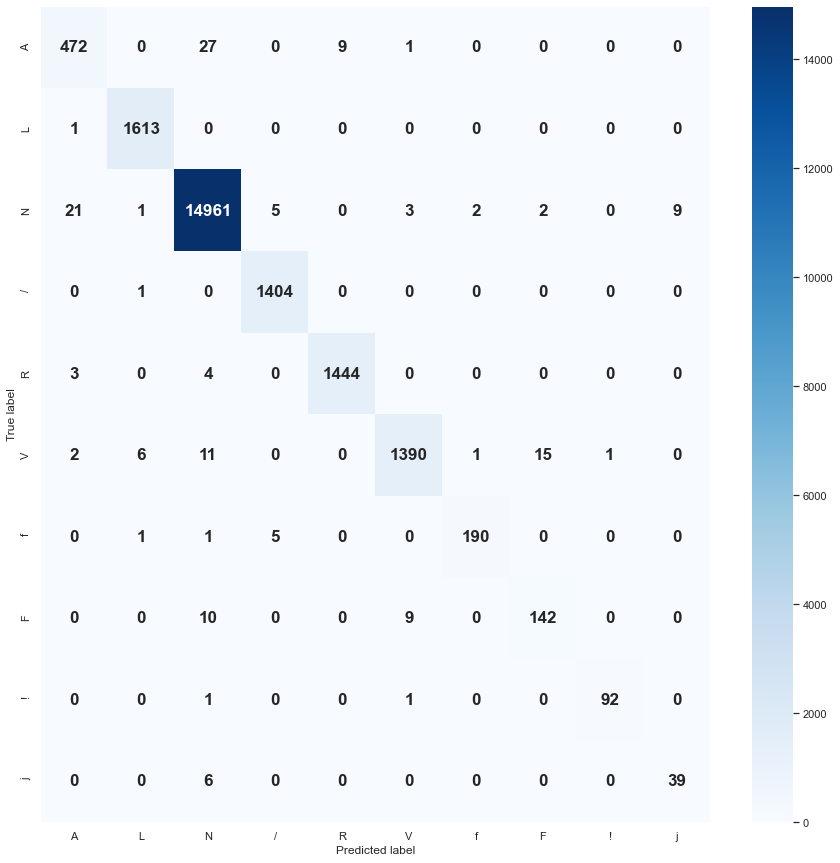



Metrics




,precision,recall,f1-score,Accuracy
A,0.945892,0.927308,0.936508,0.997078
L,0.994451,0.999380,0.996910,0.999544
N,0.996006,0.997134,0.996570,0.995298
/,0.992928,0.999288,0.996098,0.999498
R,0.993806,0.995176,0.994490,0.999270
V,0.990028,0.974755,0.982332,0.997718
f,0.984456,0.964467,0.974359,0.999544
F,0.893082,0.881988,0.887500,0.998357
!,0.989247,0.978723,0.983957,0.999863
j,0.812500,0.866667,0.838710,0.999315


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




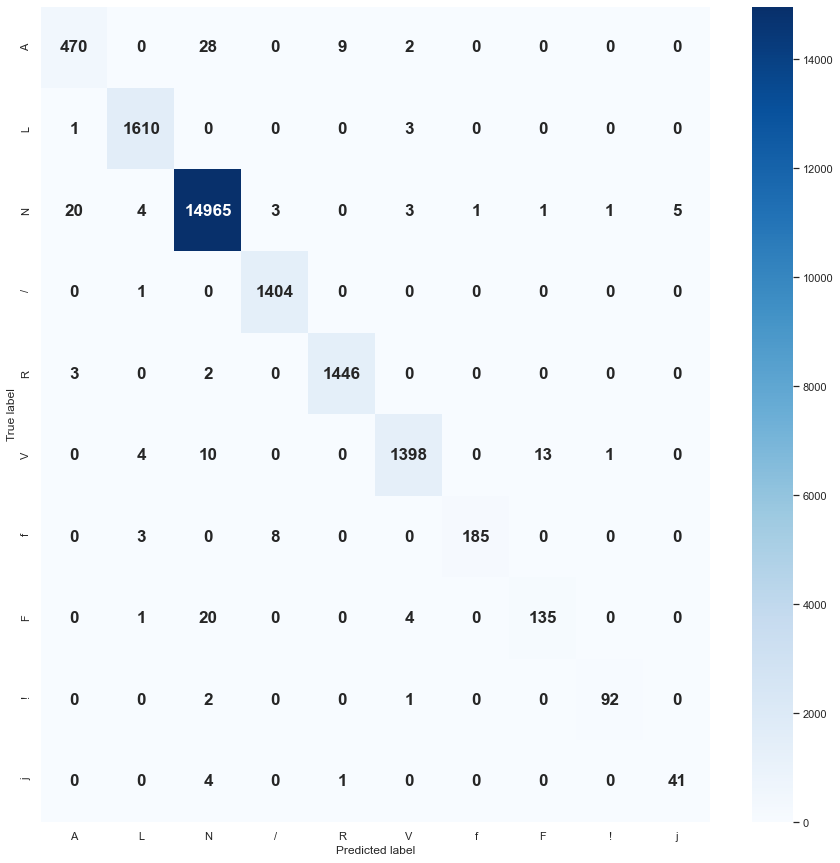



Metrics




,precision,recall,f1-score,Accuracy
A,0.951417,0.923379,0.937188,0.997124
L,0.991990,0.997522,0.994748,0.999224
N,0.995609,0.997467,0.996537,0.995252
/,0.992226,0.999288,0.995745,0.999452
R,0.993132,0.996554,0.994840,0.999315
V,0.990787,0.980365,0.985548,0.998128
f,0.994624,0.943878,0.968586,0.999452
F,0.906040,0.843750,0.873786,0.998220
!,0.978723,0.968421,0.973545,0.999772
j,0.891304,0.891304,0.891304,0.999543


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [56]:
best_val_model = ultimate_trainer(trainData=dtrain_dict,valData=dval_dict,testData=dtest_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  50
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-57-94fe076a413c>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.2905805110931396
+-> Min Training Loss : 2.2798702716827393
+-> Min Training Loss : 2.187657117843628
+-> Min Training Loss : 2.167948007583618
+-> Min Training Loss : 2.1093320846557617
+-> Min Training Loss : 2.1077487468719482
+-> Min Training Loss : 1.9805635213851929
+-> Min Training Loss : 1.917092204093933
+-> Min Training Loss : 1.7972650527954102
+-> Min Training Loss : 1.732125163078308
+-> Min Training Loss : 1.6665222644805908
+-> Min Training Loss : 1.6031076908111572
+-> Min Training Loss : 1.5420305728912354
+-> Min Training Loss : 1.5027488470077515
+-> Min Training Loss : 1.336167335510254
+-> Min Training Loss : 1.3357487916946411
+-> Min Training Loss : 1.2759714126586914
+-> Min Training Loss : 1.2141921520233154
+-> Min Training Loss : 1.172953486442566
+-> Min Training Loss : 1.1609513759613037
+-> Min Training Loss : 0.964413046836853
+-> Min Training Loss : 0.8781486749649048
+-> Min Training Loss : 0.8206200003623962
+-> Min Training L

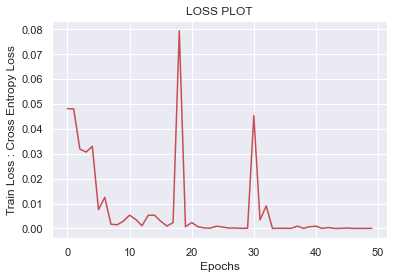

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


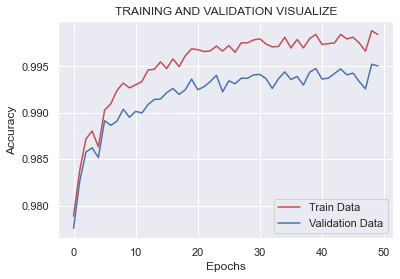

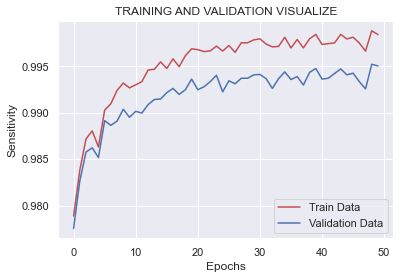

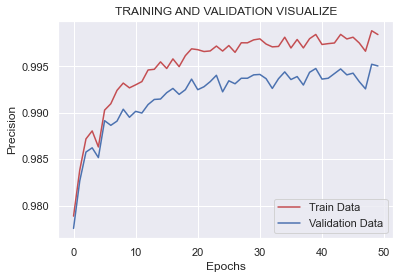

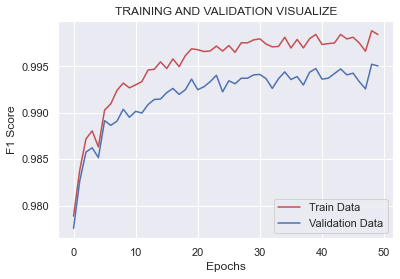

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




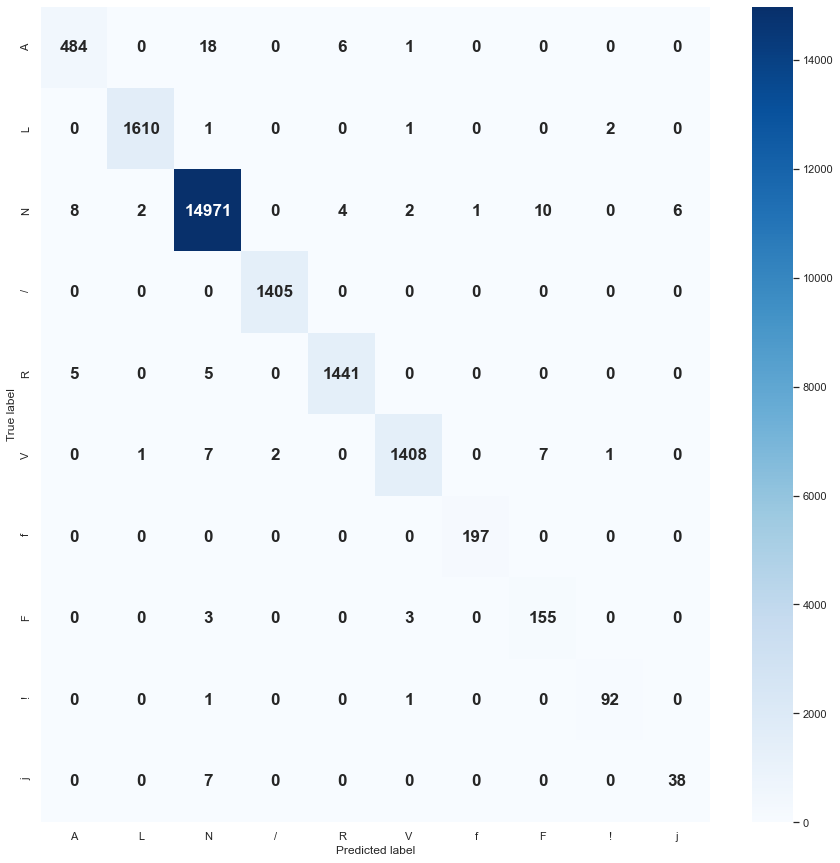



Metrics




,precision,recall,f1-score,Accuracy
A,0.973843,0.950884,0.962227,0.998265
L,0.998140,0.997522,0.997831,0.999680
N,0.997202,0.997801,0.997501,0.996576
/,0.998579,1.000000,0.999289,0.999909
R,0.993108,0.993108,0.993108,0.999087
V,0.994350,0.987377,0.990852,0.998813
f,0.994949,1.000000,0.997468,0.999954
F,0.901163,0.962733,0.930931,0.998950
!,0.968421,0.978723,0.973545,0.999772
j,0.863636,0.844444,0.853933,0.999407


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




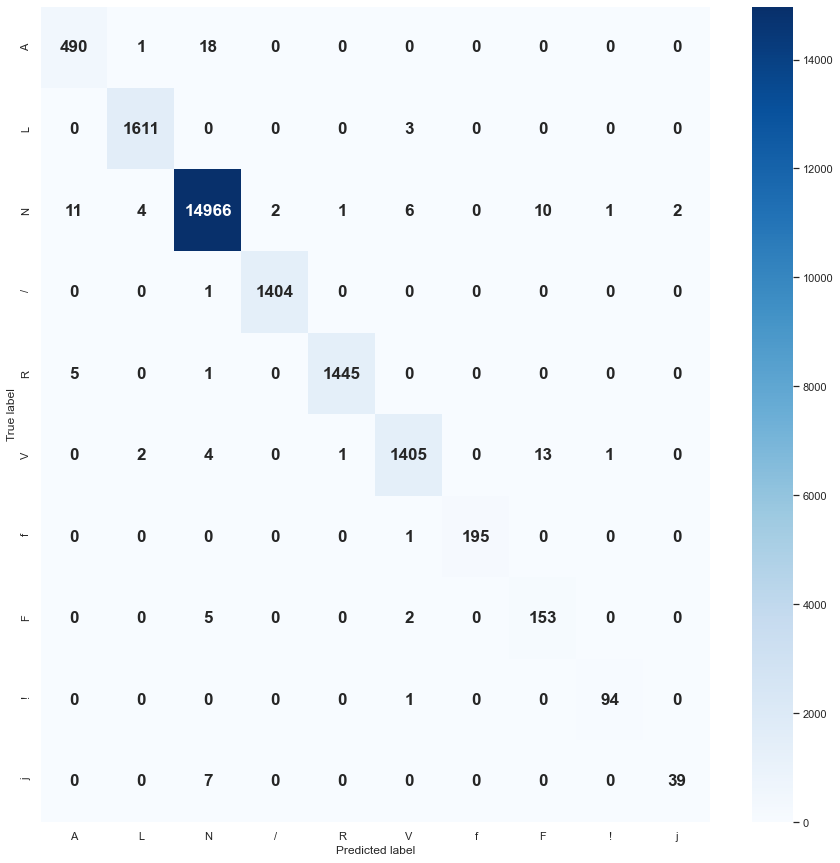



Metrics




,precision,recall,f1-score,Accuracy
A,0.968379,0.962672,0.965517,0.998402
L,0.995674,0.998141,0.996906,0.999543
N,0.997600,0.997534,0.997567,0.996667
/,0.998578,0.999288,0.998933,0.999863
R,0.998618,0.995865,0.997239,0.999635
V,0.990832,0.985273,0.988045,0.998448
f,1.000000,0.994898,0.997442,0.999954
F,0.869318,0.956250,0.910714,0.998630
!,0.979167,0.989474,0.984293,0.999863
j,0.951220,0.847826,0.896552,0.999589


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [58]:
best_val_model = ultimate_trainer(trainData=dtrain_dict,valData=dval_dict,testData=dtest_dict,epochs=50,config=config,verbose=False,visualize=True,download_model=True)

# Ablation Studies

In [52]:
def ablation_trainer(trainData,valData,testData,epochs,config,verbose=False,visualize=True,download_model=False):

    """ Trains HeartNet Models for Beat Classification -- Ablation Study"""

    print("------------------------------------------------------------------------------------------")
    print("\t\t\t ABLATION EXPERIMENT")
    print("------------------------------------------------------------------------------------------")
    print("\t ABLATION TRAINING CONFIGURATION")
    print("------------------------------------------------------------------------------------------")

    print("--> The HeartNet Model is being trained for Beat Classification -- Ablation Study "+config['ablation'])
    print("--> You are using a  " + config['device_type'])
    print("--> The epochs specified for training : ",epochs)
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING")
    print("------------------------------------------------------------------------------------------")


    # Model Instantiation and Model Parameters
    
    if config['ablation'] == "WFE":
        model = HeartNetEC_WFE(config['feature_length'])
        
    elif config['ablation'] == "WAS":
        model = HeartNetEC_WAS(config['feature_length'])
        
    elif config['ablation'] == "WSL":
        model = HeartNetEC_WSL(config['feature_length'])
        
    else:
        model = HeartNetEC(config['feature_length'])
        

    model = model.to(config['device'])

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr=config['lr'])

    # Some variables for Training and Validation Visualization
    sensitivity_plot_val = []
    precision_plot_val = []
    F1_plot_val = []
    accuracy_plot_val = []

    loss_train_plot = []
    sensitivity_plot_train = []
    precision_plot_train = []
    F1_plot_train = []
    accuracy_plot_train = []

    # Some variables for Checkpointing

    min_train_loss = 1000
    max_val_F1 = 0
    max_train_F1 = 0

    # Training

    for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):

        # Now go through each batch

        for train_batch,label_batch in zip(trainData['batches']['X'],trainData['batches']['y']):

            # Convert to Tensors

            train_batch = torch.FloatTensor(train_batch.reshape(batch_size,1,-1))

            label_batch = torch.LongTensor(label_batch)

            # Move to Specified Device

            train_batch,label_batch = train_batch.to(device),label_batch.to(device)

            # Initialize gradients to zero
            
            optimizer.zero_grad()

            # Forward Pass

            prediction = model(train_batch)

            # Compute the Loss
            

            loss = loss_fn(prediction,label_batch)

            # Backpropagation

            loss.backward()

            # Take a Step and update the parameters

            optimizer.step()

            # Now Checkpointing the model loss

            if min_train_loss > loss.item() :

                min_train_loss = loss.item()
                #best_train_model = copy.deepcopy(model.state_dict())
                print("+-> Min Training Loss : "+str(min_train_loss))

            # Freeing the GPU

            del train_batch,label_batch,prediction
            torch.cuda.empty_cache()

        # Some Bookkeeping for Training

        loss_train_plot.append(loss.item())

        # Put the Model in Evaluation Mode

        model.eval()

        # Evaluating Train Data

        train_metrics,val_metrics = evaluation(model=model,config=config,data=trainData['batches']['X'],trueLabels=trainData['y_train'],mode='Validation',name='batch_size'),evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Validation',name='batch_size_val')


        # Bookkeeping

        sensitivity_plot_train.append(train_metrics['sensitivity'])
        precision_plot_train.append(train_metrics['precision'])
        F1_plot_train.append(train_metrics['F1'])
        accuracy_plot_train.append(train_metrics['accuracy'])

        sensitivity_plot_val.append(val_metrics['sensitivity'])
        precision_plot_val.append(val_metrics['precision'])
        F1_plot_val.append(val_metrics['F1'])
        accuracy_plot_val.append(val_metrics['accuracy'])

        # Checkpointing the Best Validation Model

        if max_val_F1 < val_metrics['F1']:

            max_val_F1 = val_metrics['F1']

            best_val_model = copy.deepcopy(model.state_dict())

            print("+-> Maximum Validation F1 (in %) obtained is ",max_val_F1)

        # Put the Model back in Training Mode

        model.train()

    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING COMPLETE")
    print("------------------------------------------------------------------------------------------")
    plt.plot(loss_train_plot,'r-')
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss : Cross Entropy Loss")
    plt.title("LOSS PLOT")
    plt.show()

    if visualize :
        print("------------------------------------------------------------------------------------------")
        print("\t VISUALIZATION ")
        print("------------------------------------------------------------------------------------------")
        # Visualization

        plt.plot(accuracy_plot_train,'r-',label='Train Data')
        plt.plot(accuracy_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()


        plt.plot(sensitivity_plot_train,'r-',label='Train Data')
        plt.plot(sensitivity_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Sensitivity")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(precision_plot_train,'r-',label='Train Data')
        plt.plot(precision_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(F1_plot_train,'r-',label='Train Data')
        plt.plot(F1_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("F1 Score")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        print("------------------------------------------------------------------------------------------")
        print("\t METRICS FOR BEST VALIDATION MODEL")
        print("------------------------------------------------------------------------------------------")
        print("VALIDATION SET")
        print("------------------------------------------------------------------------------------------")

        model.load_state_dict(best_val_model)

        model.eval()

        best_metrics_val,conf_matrix_val = evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Evaluation',name='batch_size_val')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_val,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_val = pd.DataFrame.from_dict(best_metrics_val)
        df_val = df_val.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_val = df_val.drop(['support'],axis=0)
        display(df_val.T)

        print("------------------------------------------------------------------------------------------")
        print("TEST SET")
        print("------------------------------------------------------------------------------------------")

        best_metrics_test,conf_matrix_test = evaluation(model=model,config=config,data=testData['batches']['X'],trueLabels=testData['y_test'],mode='Evaluation',name='batch_size_test')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_test,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_test = pd.DataFrame.from_dict(best_metrics_test)
        df_test = df_test.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_test = df_test.drop(['support'],axis=0)
        display(df_test.T)

        print("------------------------------------------------------------------------------------------")
        print("\t EVALUATION COMPLETE")
        print("------------------------------------------------------------------------------------------")

    # Now download the model for future use

    if download_model :

        print("DOWNLOADING MODEL ...")

        torch.save(best_val_model,"HRT_NET_MODEL_ABLATION_"+config['ablation']+"_"+config['data_type'])


        print("DOWNLOADING COMPLETE !!!")


    return best_val_model

## HeartNetEC -- Without Feature Extraction Stage

In [53]:
class HeartNetEC_WFE(nn.Module):

    def __init__(self,length):


        super().__init__()
        self.length = length

        self.cl_stage_1 = nn.Sequential(
            
            nn.Linear(in_features=self.length,out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final_stage = nn.Linear(in_features=64,out_features=10)


    def forward(self,x):

        # Pass through FF Stage - 1

        cl_out_1 = self.cl_stage_1(x.squeeze())

        # Pass through the Final Classifier Stage

        final_output = self.final_stage(cl_out_1)


        return final_output

### Raw Data 

------------------------------------------------------------------------------------------
			 ABLATION EXPERIMENT
------------------------------------------------------------------------------------------
	 ABLATION TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification -- Ablation Study WFE
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-52-b131bc807de3>:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.4774155616760254
+-> Min Training Loss : 2.3094303607940674
+-> Min Training Loss : 2.081868886947632
+-> Min Training Loss : 1.8966883420944214
+-> Min Training Loss : 1.8709733486175537
+-> Min Training Loss : 1.8671947717666626
+-> Min Training Loss : 1.635306477546692
+-> Min Training Loss : 1.5353015661239624
+-> Min Training Loss : 1.4583097696304321
+-> Min Training Loss : 1.2661664485931396
+-> Min Training Loss : 1.2297968864440918
+-> Min Training Loss : 1.2264904975891113
+-> Min Training Loss : 1.1770820617675781
+-> Min Training Loss : 1.1512963771820068
+-> Min Training Loss : 1.0186470746994019
+-> Min Training Loss : 0.989440381526947
+-> Min Training Loss : 0.8950372934341431
+-> Min Training Loss : 0.849607527256012
+-> Min Training Loss : 0.7778637409210205
+-> Min Training Loss : 0.7234395146369934
+-> Min Training Loss : 0.6057206392288208
+-> Min Training Loss : 0.5995010733604431
+-> Min Training Loss : 0.5949468016624451
+-> Min Trainin

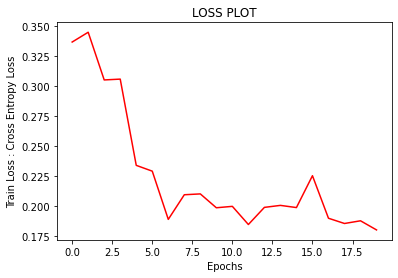

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


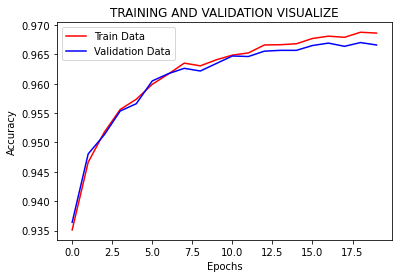

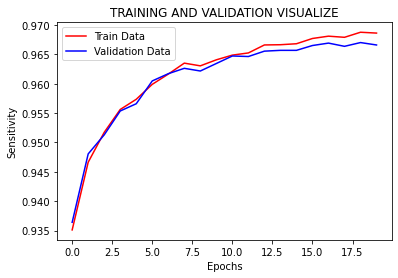

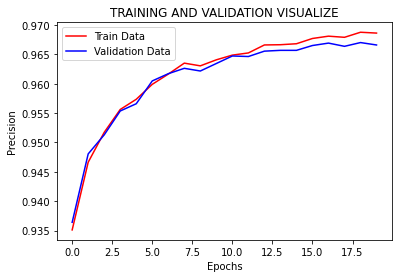

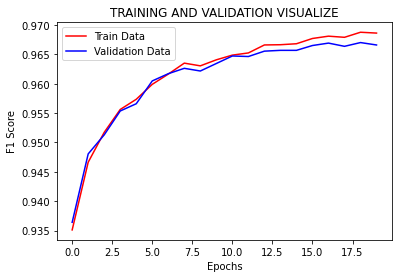

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




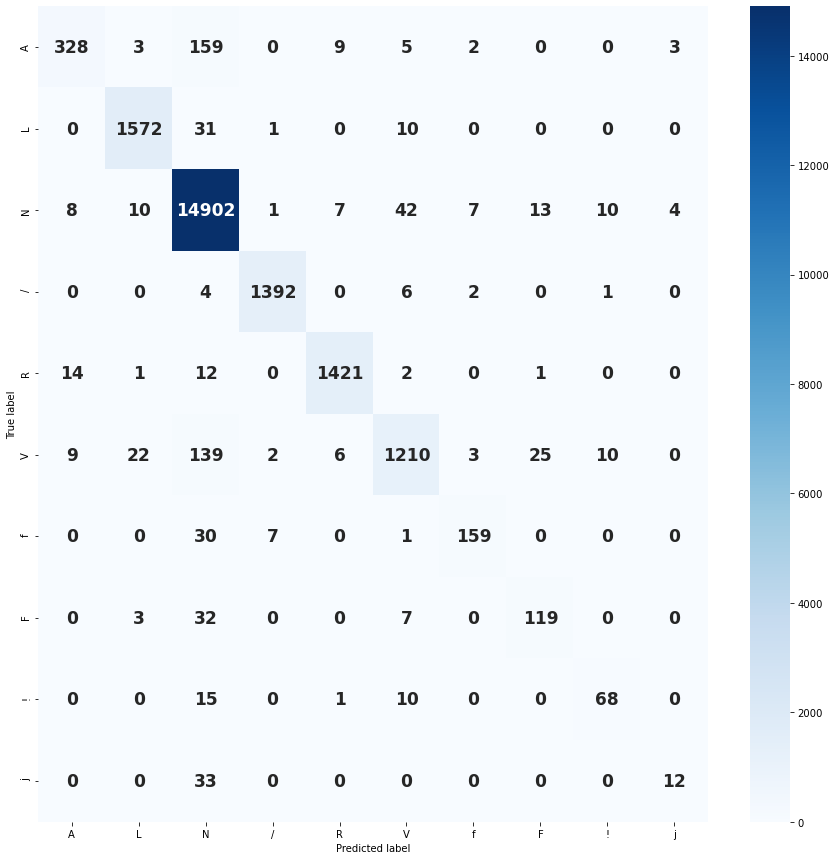



Metrics




,precision,recall,f1-score,Accuracy
A,0.913649,0.644401,0.755760,0.990322
L,0.975791,0.973978,0.974884,0.996302
N,0.970372,0.993202,0.981654,0.974573
/,0.992160,0.990747,0.991453,0.998904
R,0.984072,0.979325,0.981693,0.997581
V,0.935808,0.848527,0.890033,0.986351
f,0.919075,0.807107,0.859459,0.997626
F,0.753165,0.739130,0.746082,0.996302
!,0.764045,0.723404,0.743169,0.997854
j,0.631579,0.266667,0.375000,0.998174


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




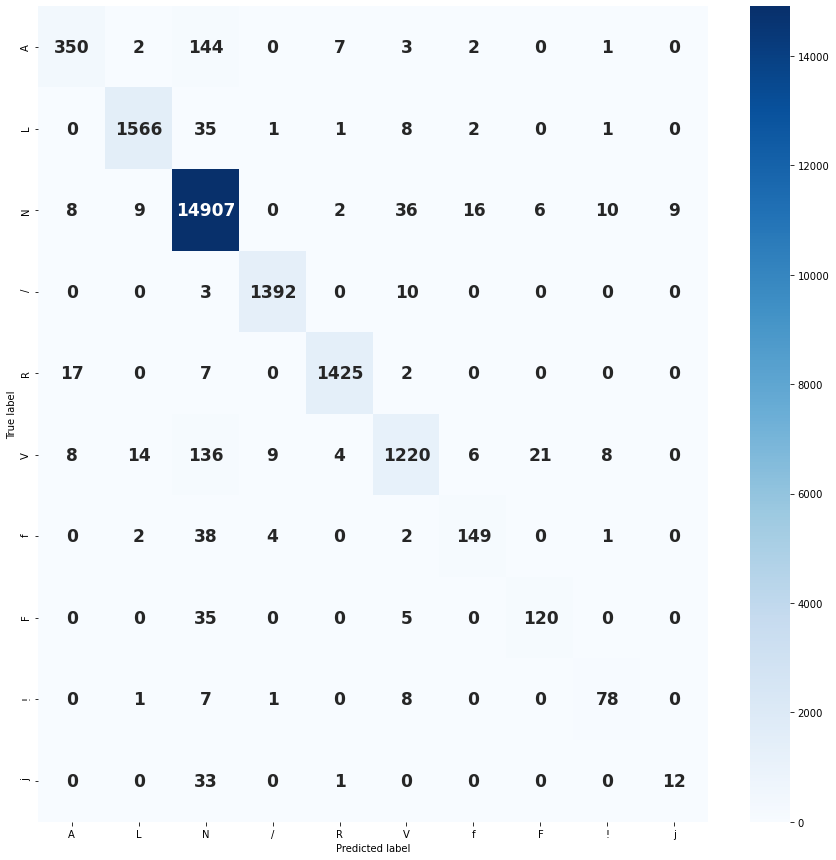



Metrics




,precision,recall,f1-score,Accuracy
A,0.913838,0.687623,0.784753,0.991235
L,0.982434,0.970260,0.976309,0.996530
N,0.971457,0.993601,0.982404,0.975622
/,0.989339,0.990747,0.990043,0.998722
R,0.989583,0.982081,0.985818,0.998128
V,0.942813,0.855540,0.897059,0.987218
f,0.851429,0.760204,0.803235,0.996667
F,0.816327,0.750000,0.781759,0.996941
!,0.787879,0.821053,0.804124,0.998265
j,0.571429,0.260870,0.358209,0.998037


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [55]:
config['ablation'] = "WFE"
config['data_type'] = "Raw"
best_val_model = ablation_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)

### Denoised Data

------------------------------------------------------------------------------------------
			 ABLATION EXPERIMENT
------------------------------------------------------------------------------------------
	 ABLATION TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification -- Ablation Study WFE
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-52-b131bc807de3>:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.4293229579925537
+-> Min Training Loss : 2.400886058807373
+-> Min Training Loss : 2.265026569366455
+-> Min Training Loss : 2.233067750930786
+-> Min Training Loss : 2.069598913192749
+-> Min Training Loss : 1.8035027980804443
+-> Min Training Loss : 1.7099844217300415
+-> Min Training Loss : 1.623659372329712
+-> Min Training Loss : 1.4318139553070068
+-> Min Training Loss : 1.3919934034347534
+-> Min Training Loss : 1.3893098831176758
+-> Min Training Loss : 1.2648791074752808
+-> Min Training Loss : 1.2573027610778809
+-> Min Training Loss : 1.1617000102996826
+-> Min Training Loss : 1.0662487745285034
+-> Min Training Loss : 1.0166575908660889
+-> Min Training Loss : 1.0011769533157349
+-> Min Training Loss : 0.8865278363227844
+-> Min Training Loss : 0.8245370984077454
+-> Min Training Loss : 0.7780203819274902
+-> Min Training Loss : 0.7701316475868225
+-> Min Training Loss : 0.7619481682777405
+-> Min Training Loss : 0.6580334305763245
+-> Min Training

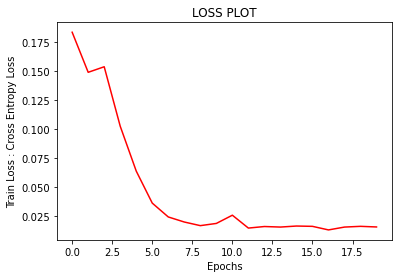

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


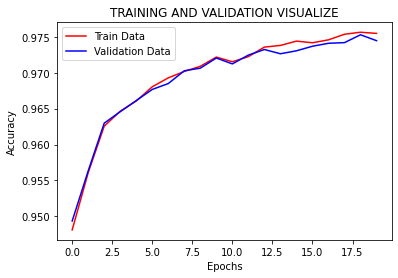

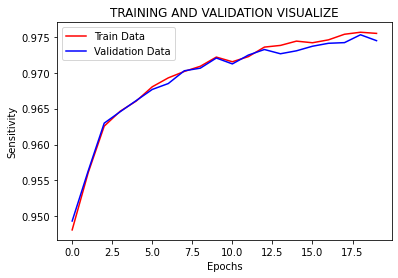

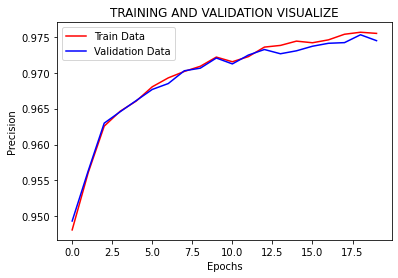

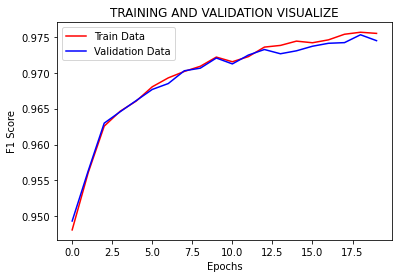

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




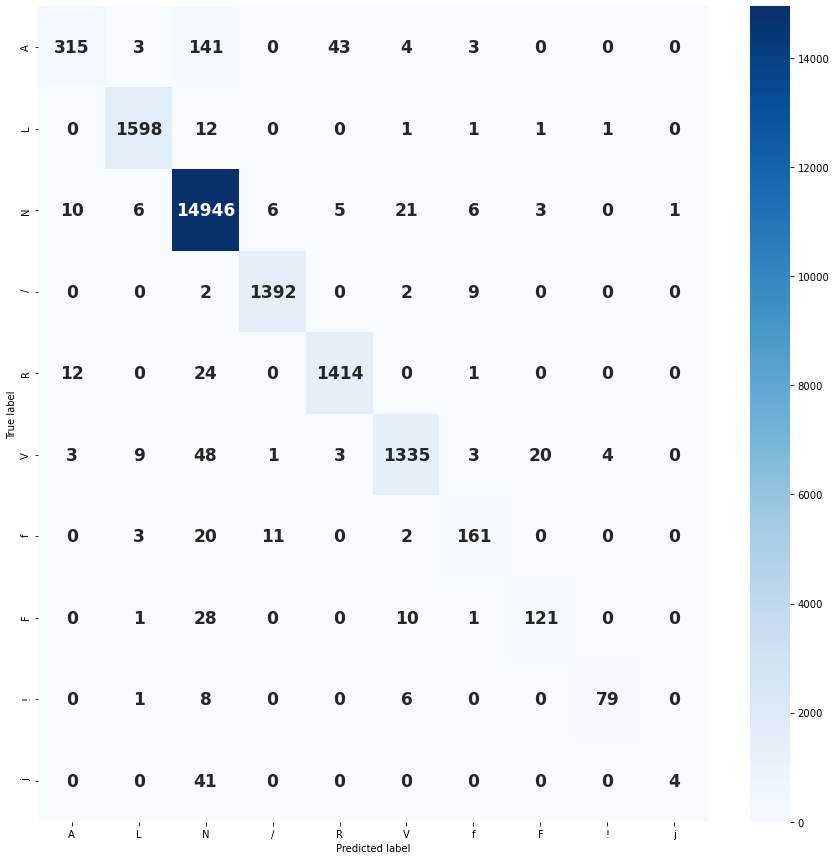



Metrics




,precision,recall,f1-score,Accuracy
A,0.926471,0.618861,0.742049,0.990003
L,0.985811,0.990087,0.987944,0.998220
N,0.978782,0.996134,0.987382,0.982562
/,0.987234,0.990747,0.988988,0.998585
R,0.965188,0.974500,0.969822,0.995983
V,0.966691,0.936185,0.951193,0.993746
f,0.870270,0.817259,0.842932,0.997261
F,0.834483,0.751553,0.790850,0.997078
!,0.940476,0.840426,0.887640,0.999087
j,0.800000,0.088889,0.160000,0.998083


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




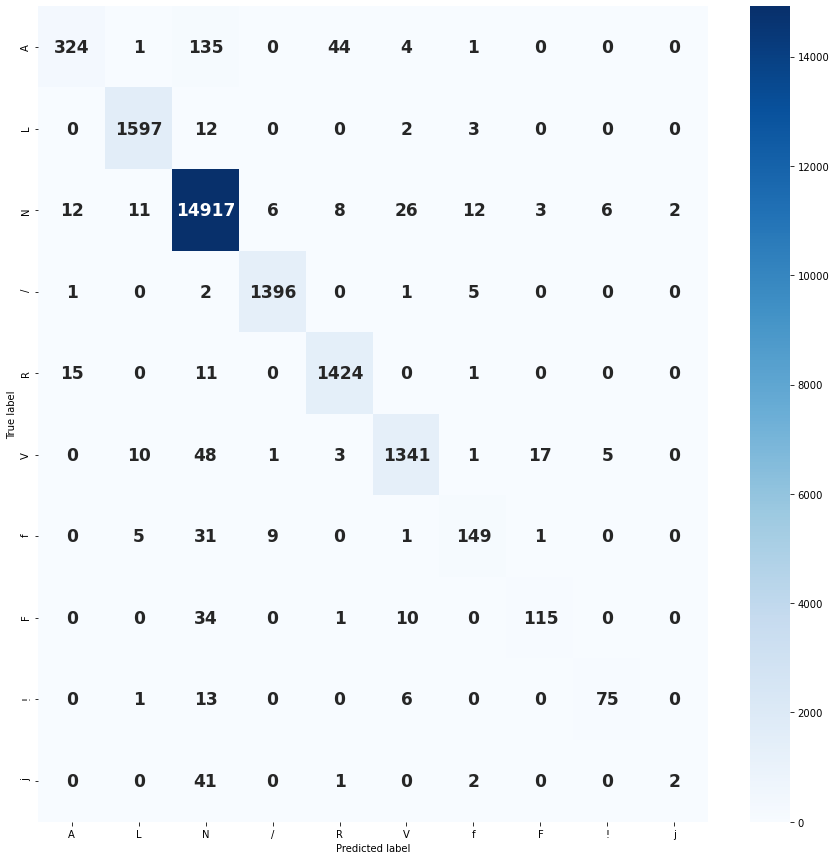



Metrics




,precision,recall,f1-score,Accuracy
A,0.920455,0.636542,0.752613,0.990276
L,0.982769,0.989467,0.986107,0.997946
N,0.978549,0.994268,0.986346,0.981146
/,0.988669,0.993594,0.991125,0.998859
R,0.961512,0.981392,0.971351,0.996165
V,0.964055,0.940393,0.952077,0.993837
f,0.856322,0.760204,0.805405,0.996713
F,0.845588,0.718750,0.777027,0.996987
!,0.872093,0.789474,0.828729,0.998585
j,0.500000,0.043478,0.080000,0.997900


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [56]:
config['data_type'] = "Denoised"
best_val_model = ablation_trainer(trainData=dtrain_dict,valData=dval_dict,testData=dtest_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)

## HeartNetEC -- Without Ascend Stages

In [57]:
class HeartNetEC_WAS(nn.Module):

    def __init__(self,length):


        super().__init__()
        self.length = length

        self.descend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=1,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,1,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (1,4,L) --> (1,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.descend_Stage1_i_Stage2 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,4,L) --> (N,4,L/2)

        self.descend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=4,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,4,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.descend_Stage2_i_Stage3 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,8,L/2) --> (N,8,L/4)

        self.descend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=8,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,8,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),#(N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.descend_Stage3_i_Stage4 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,16,L/4) --> (N,16,L/8)

        self.descend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=16,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,16,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.descend_Stage4_i_floor = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,32,L/8) --> (N,32,L/16)

        self.floor = nn.Sequential(

            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,32,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU(),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,64,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU()
        )

        self.fe_output = nn.Conv1d(in_channels=64,out_channels=1,kernel_size=1)          # (N,4,L) --> (N,1,L)

        self.cl_stage_1 = nn.Sequential(
            
            nn.Linear(in_features=18,out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final_stage = nn.Linear(in_features=64,out_features=10)


    def forward(self,x):

  

        # Pass through Descend Stage-1

        d_1 = self.descend_Stage1(x)



        # Move to Descend Stage-2

        d_1_i_2 = self.descend_Stage1_i_Stage2(d_1)

 

        # Pass through Descend Stage-2

        d_2 = self.descend_Stage2(d_1_i_2)

  

        # Move to Descend Stage-3

        d_2_i_3 = self.descend_Stage2_i_Stage3(d_2)



        # Pass through Descend Stage-3

        d_3 = self.descend_Stage3(d_2_i_3)



        # Move to Descend Stage-4


        d_3_i_4 = self.descend_Stage3_i_Stage4(d_3)



        # Pass through Descend Stage-4

        d_4 = self.descend_Stage4(d_3_i_4)



        # Move to Floor

        d_4_i_f = self.descend_Stage4_i_floor(d_4)



        # Pass through Floor

        d_f = self.floor(d_4_i_f)



        fe_output = self.fe_output(d_f)

        # Pass through FF Stage - 1

        cl_out_1 = self.cl_stage_1(fe_output.squeeze())

        # Pass through the Final Classifier Stage

        final_output = self.final_stage(cl_out_1)


        return final_output

### Raw Data

------------------------------------------------------------------------------------------
			 ABLATION EXPERIMENT
------------------------------------------------------------------------------------------
	 ABLATION TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification -- Ablation Study WAS
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-52-b131bc807de3>:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.1995761394500732
+-> Min Training Loss : 2.145181894302368
+-> Min Training Loss : 1.9990872144699097
+-> Min Training Loss : 1.8822370767593384
+-> Min Training Loss : 1.742631435394287
+-> Min Training Loss : 1.7127037048339844
+-> Min Training Loss : 1.6508772373199463
+-> Min Training Loss : 1.5461217164993286
+-> Min Training Loss : 1.4503527879714966
+-> Min Training Loss : 1.403406023979187
+-> Min Training Loss : 1.3641592264175415
+-> Min Training Loss : 1.3338452577590942
+-> Min Training Loss : 1.2164214849472046
+-> Min Training Loss : 1.2145494222640991
+-> Min Training Loss : 1.1538963317871094
+-> Min Training Loss : 1.0905152559280396
+-> Min Training Loss : 1.0010722875595093
+-> Min Training Loss : 0.9882276058197021
+-> Min Training Loss : 0.9244449734687805
+-> Min Training Loss : 0.9060134887695312
+-> Min Training Loss : 0.8193985819816589
+-> Min Training Loss : 0.6941003203392029
+-> Min Training Loss : 0.5907543897628784
+-> Min Traini

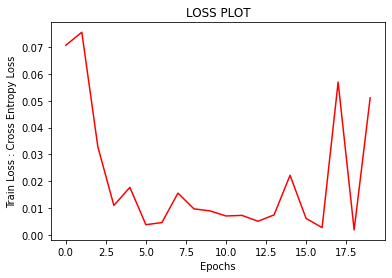

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


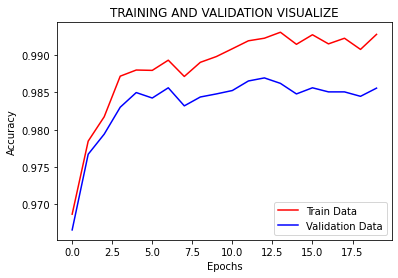

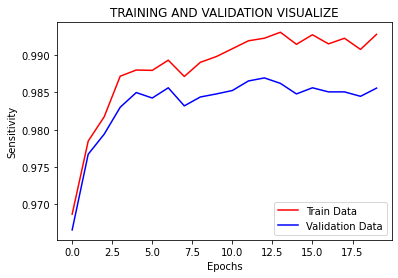

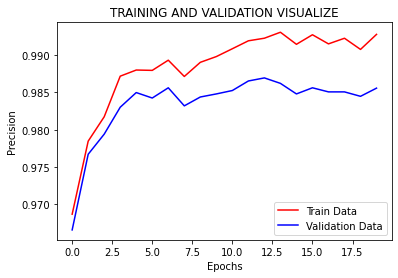

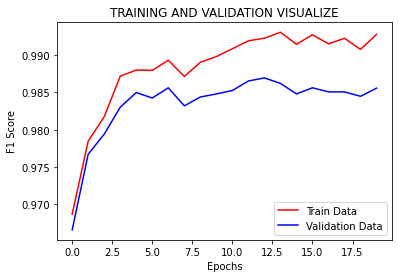

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




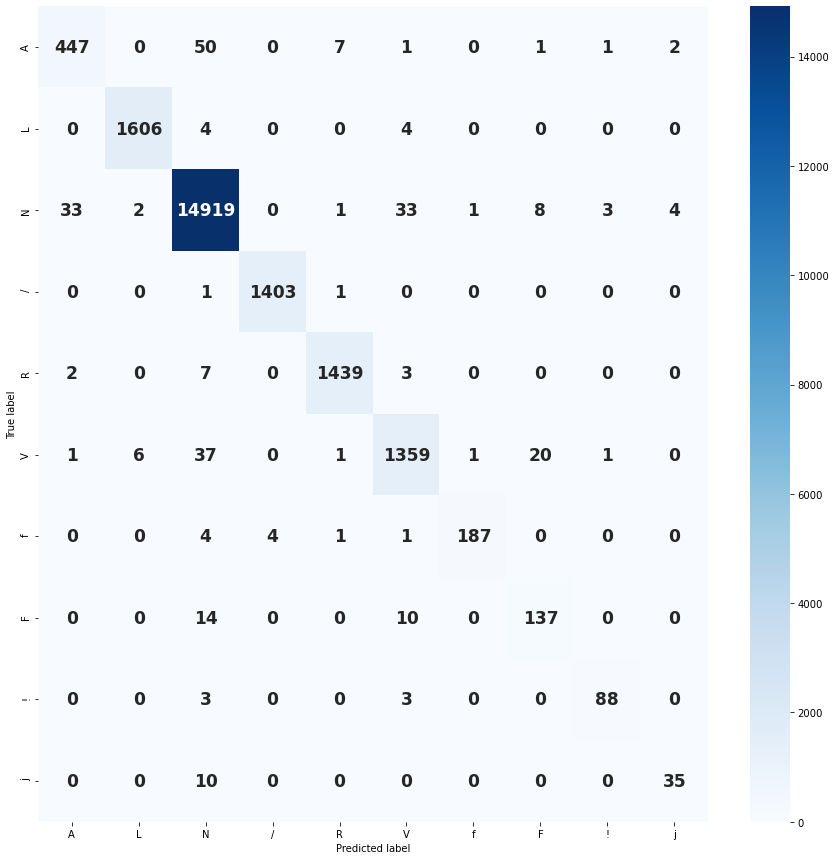



Metrics




,precision,recall,f1-score,Accuracy
A,0.925466,0.878193,0.901210,0.995526
L,0.995043,0.995043,0.995043,0.999270
N,0.991362,0.994335,0.992846,0.990185
/,0.997157,0.998577,0.997866,0.999726
R,0.992414,0.991730,0.992072,0.998950
V,0.961103,0.953015,0.957042,0.994431
f,0.989418,0.949239,0.968912,0.999452
F,0.825301,0.850932,0.837920,0.997581
!,0.946237,0.936170,0.941176,0.999498
j,0.853659,0.777778,0.813953,0.999270


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




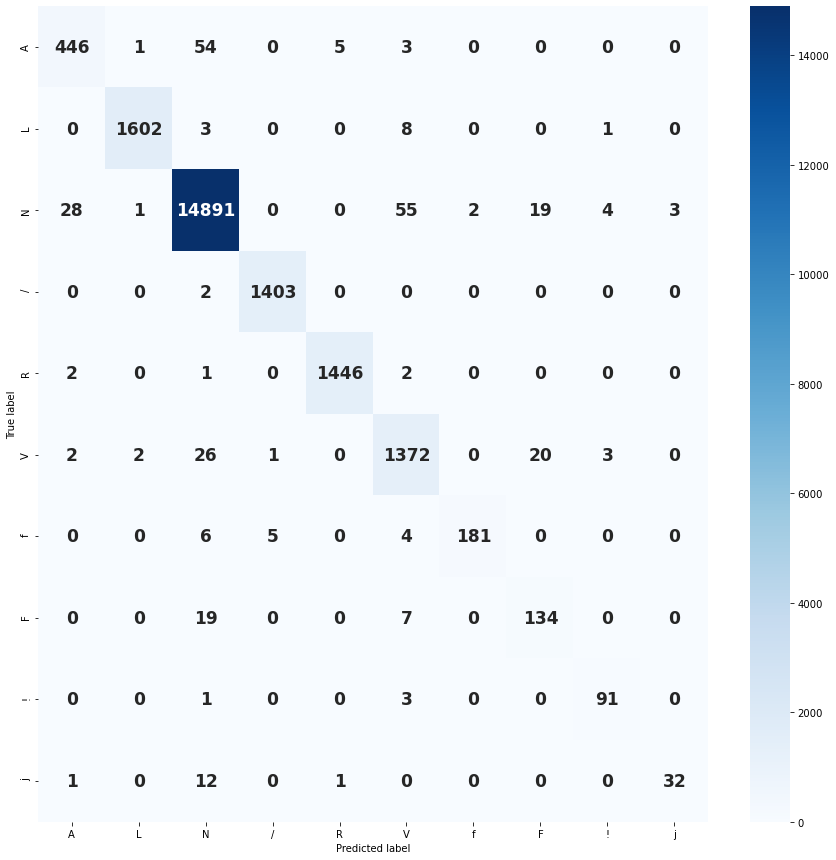



Metrics




,precision,recall,f1-score,Accuracy
A,0.931106,0.876228,0.902834,0.995617
L,0.997509,0.992565,0.995031,0.999270
N,0.991742,0.992535,0.992138,0.989226
/,0.995742,0.998577,0.997157,0.999635
R,0.995868,0.996554,0.996211,0.999498
V,0.943604,0.962132,0.952778,0.993791
f,0.989071,0.923469,0.955145,0.999224
F,0.774566,0.837500,0.804805,0.997033
!,0.919192,0.957895,0.938144,0.999452
j,0.914286,0.695652,0.790123,0.999224


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [58]:
config['ablation'] = "WAS"
config['data_type'] = "RAW"
best_val_model = ablation_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)


------------------------------------------------------------------------------------------
			 ABLATION EXPERIMENT
------------------------------------------------------------------------------------------
	 ABLATION TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification -- Ablation Study WAS
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-52-b131bc807de3>:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.3747265338897705
+-> Min Training Loss : 2.3022732734680176
+-> Min Training Loss : 2.222200632095337
+-> Min Training Loss : 2.18027663230896
+-> Min Training Loss : 2.1041057109832764
+-> Min Training Loss : 2.022695779800415
+-> Min Training Loss : 1.9990036487579346
+-> Min Training Loss : 1.857612133026123
+-> Min Training Loss : 1.7500603199005127
+-> Min Training Loss : 1.72004234790802
+-> Min Training Loss : 1.6746602058410645
+-> Min Training Loss : 1.62664794921875
+-> Min Training Loss : 1.533499836921692
+-> Min Training Loss : 1.4505261182785034
+-> Min Training Loss : 1.445715069770813
+-> Min Training Loss : 1.408298134803772
+-> Min Training Loss : 1.3686217069625854
+-> Min Training Loss : 1.316829800605774
+-> Min Training Loss : 1.2710598707199097
+-> Min Training Loss : 1.2122689485549927
+-> Min Training Loss : 1.1342885494232178
+-> Min Training Loss : 1.0327123403549194
+-> Min Training Loss : 0.926906406879425
+-> Min Training Loss : 0

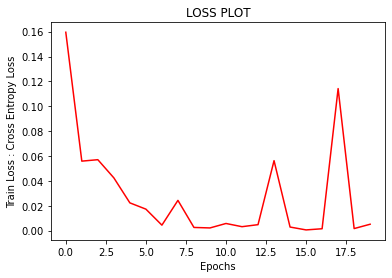

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


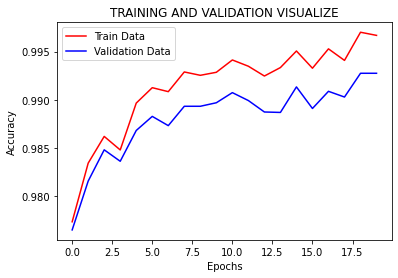

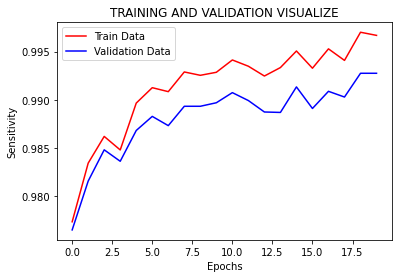

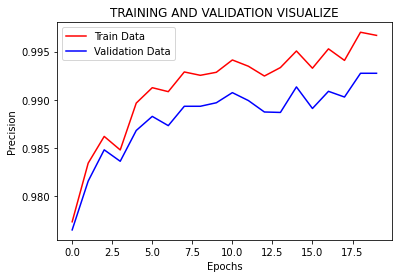

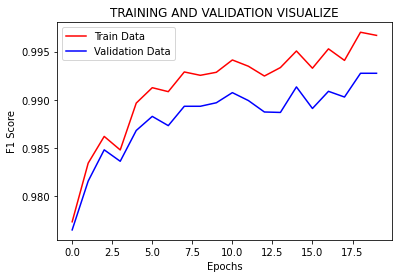

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




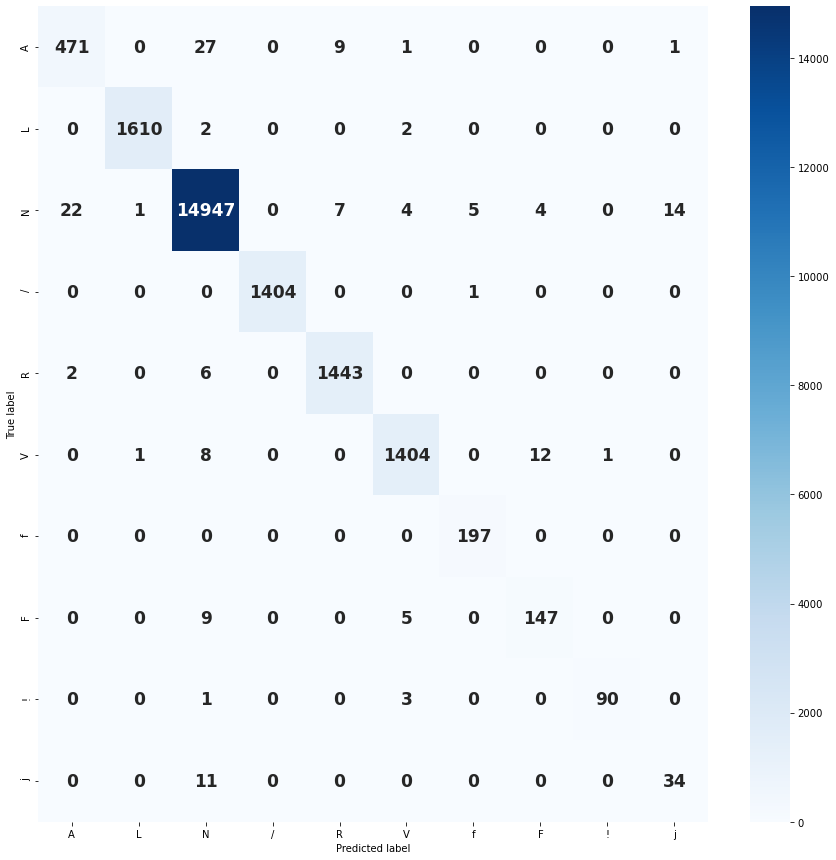



Metrics




,precision,recall,f1-score,Accuracy
A,0.951515,0.925344,0.938247,0.997170
L,0.998759,0.997522,0.998140,0.999726
N,0.995736,0.996201,0.995969,0.994476
/,1.000000,0.999288,0.999644,0.999954
R,0.989034,0.994487,0.991753,0.998904
V,0.989429,0.984572,0.986995,0.998311
f,0.970443,1.000000,0.985000,0.999726
F,0.901840,0.913043,0.907407,0.998631
!,0.989011,0.957447,0.972973,0.999772
j,0.693878,0.755556,0.723404,0.998813


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




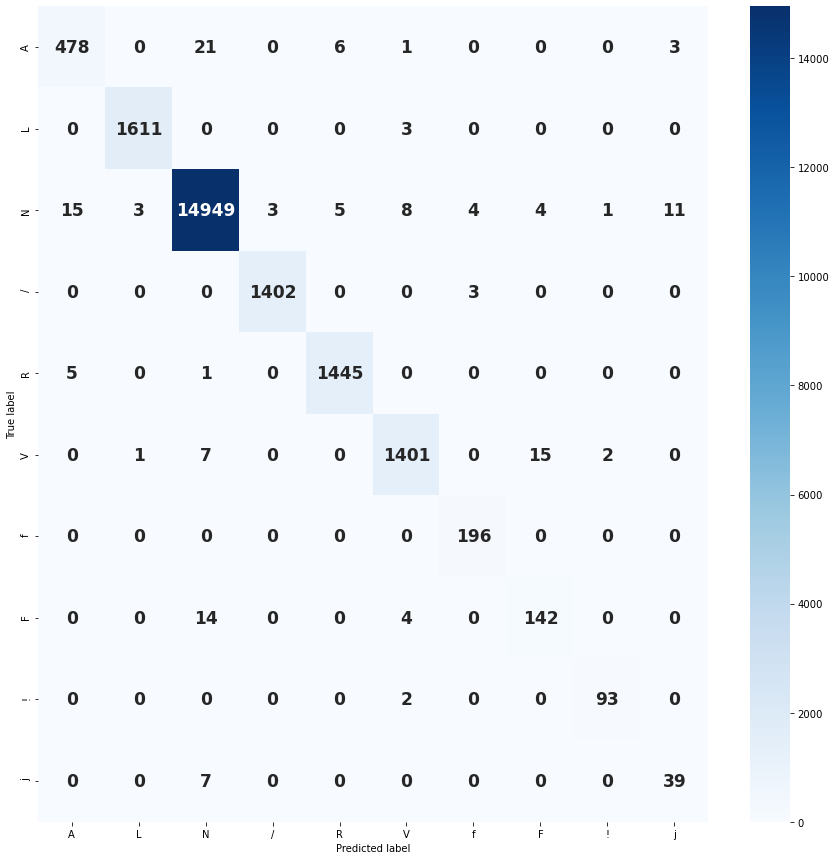



Metrics




,precision,recall,f1-score,Accuracy
A,0.959839,0.939096,0.949355,0.997672
L,0.997523,0.998141,0.997832,0.999680
N,0.996666,0.996401,0.996534,0.995252
/,0.997865,0.997865,0.997865,0.999726
R,0.992445,0.995865,0.994152,0.999224
V,0.987315,0.982468,0.984886,0.998037
f,0.965517,1.000000,0.982456,0.999680
F,0.881988,0.887500,0.884735,0.998311
!,0.968750,0.978947,0.973822,0.999772
j,0.735849,0.847826,0.787879,0.999041


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [59]:
config['data_type'] = "DENOISED"
best_val_model = ablation_trainer(trainData=dtrain_dict,valData=dval_dict,testData=dtest_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)


## HeartNetEC -- Without Descend-Ascend Connection/Skip Links

In [60]:
class HeartNetEC_WSL(nn.Module):

    def __init__(self,length):


        super().__init__()
        self.length = length

        self.descend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=1,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,1,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (1,4,L) --> (1,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.descend_Stage1_i_Stage2 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,4,L) --> (N,4,L/2)

        self.descend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=4,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,4,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.descend_Stage2_i_Stage3 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,8,L/2) --> (N,8,L/4)

        self.descend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=8,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,8,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),#(N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.descend_Stage3_i_Stage4 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,16,L/4) --> (N,16,L/8)

        self.descend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=16,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,16,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.descend_Stage4_i_floor = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,32,L/8) --> (N,32,L/16)

        self.floor = nn.Sequential(

            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,32,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU(),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,64,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU()
        )

        self.ascend_floor_i_Stage4 = nn.ConvTranspose1d(in_channels=64,out_channels=64,kernel_size=8,stride=2,padding=3) # (N,64,L/16) --> (N,64,L/8)

        self.ascend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=64,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,96,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.ascend_Stage4_i_Stage3 = nn.ConvTranspose1d(in_channels=32,out_channels=32,kernel_size=8,stride=2,padding=3) # (N,32,L/8) --> (N,32,L/4)

        self.ascend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,48,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.ascend_Stage3_i_Stage2 = nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=8,stride=2,padding=3) # (N,16,L/4) --> (N,16,L/2)

        self.ascend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=16,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,24,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.ascend_Stage2_i_Stage1 = nn.ConvTranspose1d(in_channels=8,out_channels=8,kernel_size=8,stride=2,padding=3) # (N,8,L/2) --> (N,8,L)

        self.ascend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=8,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,12,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,4,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.fe_output = nn.Conv1d(in_channels=4,out_channels=1,kernel_size=1)          # (N,4,L) --> (N,1,L)

        self.cl_stage_1 = nn.Sequential(
            
            nn.Linear(in_features=self.length,out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final_stage = nn.Linear(in_features=64,out_features=10)


    def forward(self,x):

  

        # Pass through Descend Stage-1

        d_1 = self.descend_Stage1(x)



        # Move to Descend Stage-2

        d_1_i_2 = self.descend_Stage1_i_Stage2(d_1)

 

        # Pass through Descend Stage-2

        d_2 = self.descend_Stage2(d_1_i_2)

  

        # Move to Descend Stage-3

        d_2_i_3 = self.descend_Stage2_i_Stage3(d_2)



        # Pass through Descend Stage-3

        d_3 = self.descend_Stage3(d_2_i_3)



        # Move to Descend Stage-4


        d_3_i_4 = self.descend_Stage3_i_Stage4(d_3)



        # Pass through Descend Stage-4

        d_4 = self.descend_Stage4(d_3_i_4)



        # Move to Floor

        d_4_i_f = self.descend_Stage4_i_floor(d_4)



        # Pass through Floor

        d_f = self.floor(d_4_i_f)



        # Move to Ascend Stage-4

        a_f_i_4 = self.ascend_floor_i_Stage4(d_f)


        # Prepare for Ascend Stage-4



        #a_p_4 = torch.cat((d_4,a_f_i_4),dim=1)


        # Pass through Ascend Stage-4


        a_4 = self.ascend_Stage4(a_f_i_4)


        # Move to Ascend Stage-3


        a_4_i_3 = self.ascend_Stage4_i_Stage3(a_4)


        # Prepare for Ascend Stage-3


        #a_p_3 = torch.cat((d_3,a_4_i_3),dim=1)


        # Pass through Ascend Stage-3


        a_3 = self.ascend_Stage3(a_4_i_3)


        # Move to Ascend Stage-2

        a_3_i_2 = self.ascend_Stage3_i_Stage2(a_3)


        # Prepare for Ascend Stage-2

        #a_p_2 = torch.cat((d_2,a_3_i_2),dim=1)


        # Pass through Stage-2

        a_2 = self.ascend_Stage2(a_3_i_2)


        # Move to Ascend Stage-1

        a_2_i_1 = self.ascend_Stage2_i_Stage1(a_2)



        # Prepare for Ascend Stage-1

        #a_p_1 = torch.cat((d_1,a_2_i_1),dim=1)


        # Pass through Ascend Stage-1


        a_1 = self.ascend_Stage1(a_2_i_1)


        # Pass through Final Stage of Feature Extractor


        fe_output = self.fe_output(a_1)

        # Pass through FF Stage - 1

        cl_out_1 = self.cl_stage_1(fe_output.squeeze())

        # Pass through the Final Classifier Stage

        final_output = self.final_stage(cl_out_1)


        return final_output

------------------------------------------------------------------------------------------
			 ABLATION EXPERIMENT
------------------------------------------------------------------------------------------
	 ABLATION TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification -- Ablation Study WSL
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-52-b131bc807de3>:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.4406912326812744
+-> Min Training Loss : 2.2903761863708496
+-> Min Training Loss : 2.249664545059204
+-> Min Training Loss : 2.1674795150756836
+-> Min Training Loss : 2.1596577167510986
+-> Min Training Loss : 2.066582679748535
+-> Min Training Loss : 2.017582416534424
+-> Min Training Loss : 1.990136742591858
+-> Min Training Loss : 1.8884873390197754
+-> Min Training Loss : 1.8716061115264893
+-> Min Training Loss : 1.6576383113861084
+-> Min Training Loss : 1.5006718635559082
+-> Min Training Loss : 1.414389729499817
+-> Min Training Loss : 1.355114221572876
+-> Min Training Loss : 1.3159050941467285
+-> Min Training Loss : 1.2831400632858276
+-> Min Training Loss : 1.2550396919250488
+-> Min Training Loss : 1.029482364654541
+-> Min Training Loss : 0.9430879950523376
+-> Min Training Loss : 0.8455619812011719
+-> Min Training Loss : 0.679817259311676
+-> Min Training Loss : 0.6305677890777588
+-> Min Training Loss : 0.4920177459716797
+-> Min Training Lo

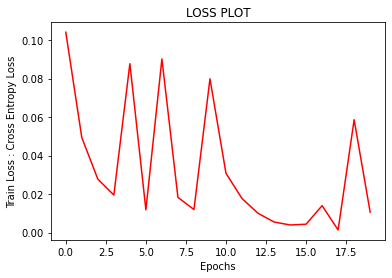

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


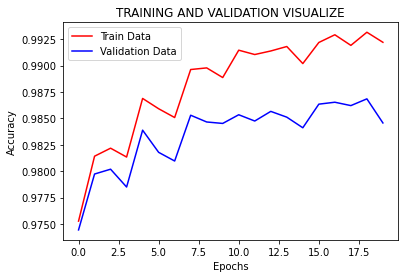

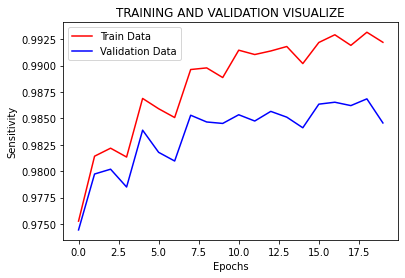

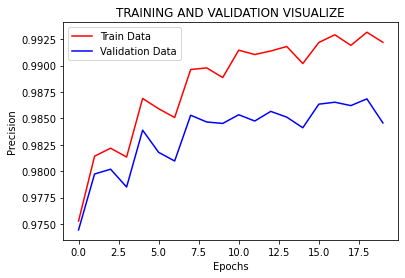

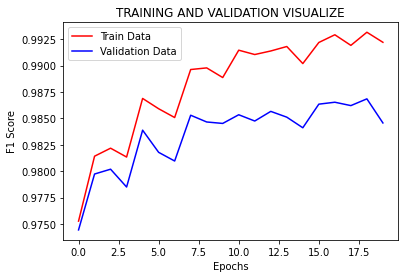

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




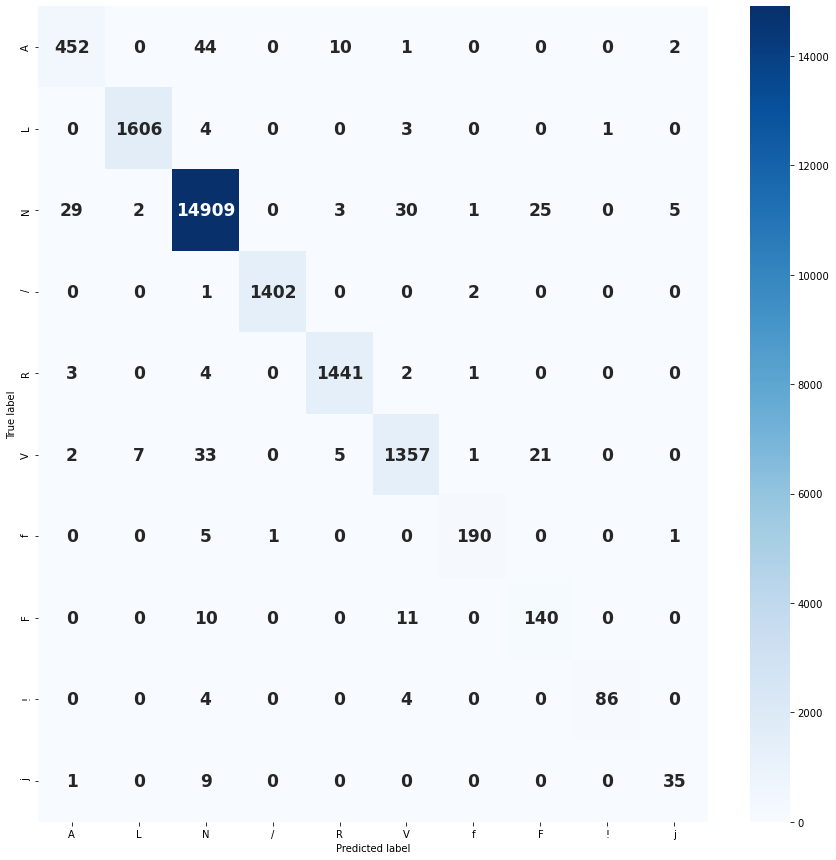



Metrics




,precision,recall,f1-score,Accuracy
A,0.928131,0.888016,0.907631,0.995800
L,0.994427,0.995043,0.994735,0.999224
N,0.992412,0.993668,0.993040,0.990459
/,0.999287,0.997865,0.998575,0.999817
R,0.987663,0.993108,0.990378,0.998722
V,0.963778,0.951613,0.957657,0.994522
f,0.974359,0.964467,0.969388,0.999452
F,0.752688,0.869565,0.806916,0.996941
!,0.988506,0.914894,0.950276,0.999589
j,0.813953,0.777778,0.795455,0.999178


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




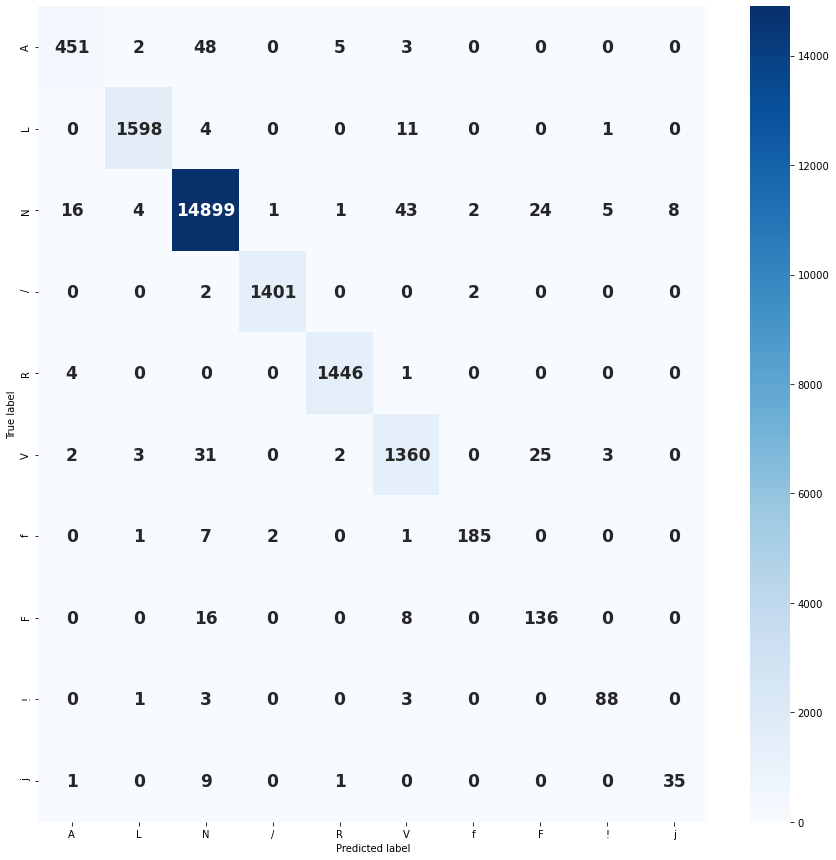



Metrics




,precision,recall,f1-score,Accuracy
A,0.951477,0.886051,0.917599,0.996302
L,0.993163,0.990087,0.991623,0.998767
N,0.992010,0.993068,0.992539,0.989774
/,0.997863,0.997153,0.997508,0.999680
R,0.993814,0.996554,0.995182,0.999361
V,0.951049,0.953717,0.952381,0.993791
f,0.978836,0.943878,0.961039,0.999315
F,0.735135,0.850000,0.788406,0.996667
!,0.907216,0.926316,0.916667,0.999270
j,0.813953,0.760870,0.786517,0.999133


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [61]:
config['ablation'] = "WSL"
config['data_type'] = "RAW"
best_val_model = ablation_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)


------------------------------------------------------------------------------------------
			 ABLATION EXPERIMENT
------------------------------------------------------------------------------------------
	 ABLATION TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification -- Ablation Study WSL
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-52-b131bc807de3>:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.22635817527771
+-> Min Training Loss : 1.9706650972366333
+-> Min Training Loss : 1.9000844955444336
+-> Min Training Loss : 1.8454471826553345
+-> Min Training Loss : 1.7552114725112915
+-> Min Training Loss : 1.6390113830566406
+-> Min Training Loss : 1.605141520500183
+-> Min Training Loss : 1.513348937034607
+-> Min Training Loss : 1.5000431537628174
+-> Min Training Loss : 1.3411461114883423
+-> Min Training Loss : 1.24283766746521
+-> Min Training Loss : 1.2137027978897095
+-> Min Training Loss : 1.2078403234481812
+-> Min Training Loss : 1.0121709108352661
+-> Min Training Loss : 0.9884245991706848
+-> Min Training Loss : 0.7748255729675293
+-> Min Training Loss : 0.6417611837387085
+-> Min Training Loss : 0.5459595918655396
+-> Min Training Loss : 0.5272852182388306
+-> Min Training Loss : 0.39494842290878296
+-> Min Training Loss : 0.3608109652996063
+-> Min Training Loss : 0.35732394456863403
+-> Min Training Loss : 0.29964905977249146
+-> Min Traini

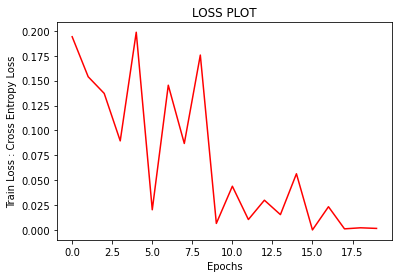

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


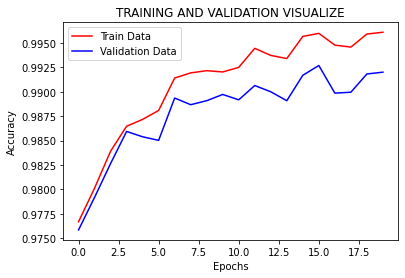

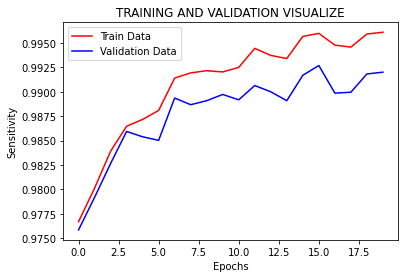

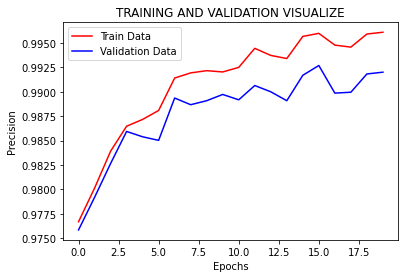

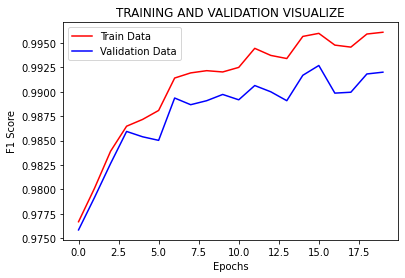

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




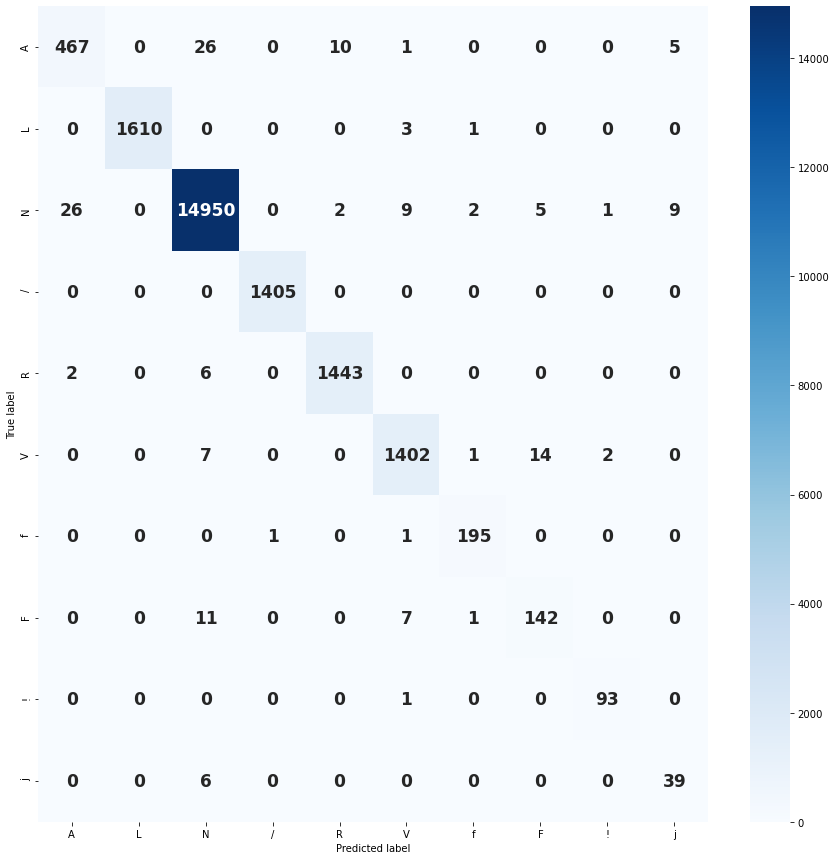



Metrics




,precision,recall,f1-score,Accuracy
A,0.943434,0.917485,0.930279,0.996805
L,1.000000,0.997522,0.998759,0.999817
N,0.996268,0.996401,0.996335,0.994979
/,0.999289,1.000000,0.999644,0.999954
R,0.991753,0.994487,0.993118,0.999087
V,0.984551,0.983170,0.983860,0.997900
f,0.975000,0.989848,0.982368,0.999680
F,0.881988,0.881988,0.881988,0.998265
!,0.968750,0.989362,0.978947,0.999817
j,0.735849,0.866667,0.795918,0.999087


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




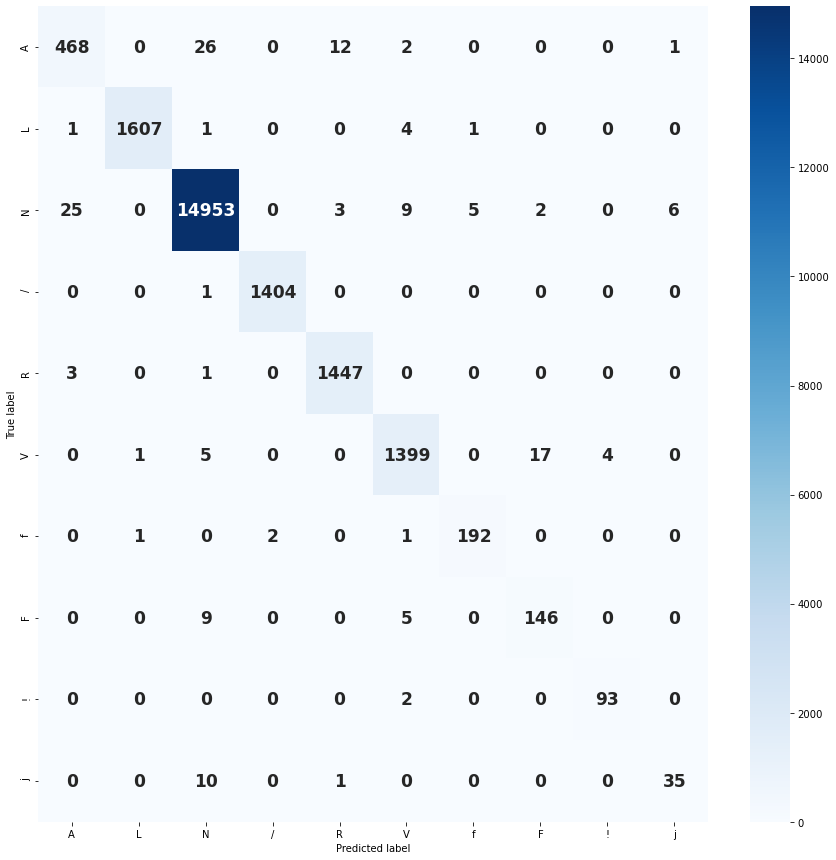



Metrics




,precision,recall,f1-score,Accuracy
A,0.941650,0.919450,0.930417,0.996804
L,0.998757,0.995663,0.997208,0.999589
N,0.996468,0.996667,0.996568,0.995298
/,0.998578,0.999288,0.998933,0.999863
R,0.989064,0.997243,0.993137,0.999087
V,0.983826,0.981066,0.982444,0.997717
f,0.969697,0.979592,0.974619,0.999543
F,0.884848,0.912500,0.898462,0.998493
!,0.958763,0.978947,0.968750,0.999726
j,0.833333,0.760870,0.795455,0.999178


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [62]:
config['data_type'] = "DENOISED"
best_val_model = ablation_trainer(trainData=dtrain_dict,valData=dval_dict,testData=dtest_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)
